# SLAMseq

## Installing slamdunk (only do once)

In [1]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [2]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

In [2]:
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../../')
import seaborn as sns
import numpy as np

from genepy.utils import helper as h
from genepy.utils import plot as genepyPlot
from genepy.rna import pyDESeq2
import genepy.rna as rna

from natsort import natsorted, ns

from bokeh.plotting import *
from bokeh.models import HoverTool
from bokeh.io import output_notebook

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

output_notebook()
%load_ext autoreload
%matplotlib inline
%autoreload 2
%load_ext rpy2.ipython

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
def createDir(directory):
    if not os.path.exists(directory):
        print("Creating output directory: " + directory)
        os.makedirs(directory)

# MYB degron time course (no alt loci)

In [4]:
project = "MYB_degraded_timecourse_v1"

__Rerun samples__
* 1hr DMSO: rep 1
* 12hr DMSO: all
* 12hr VHL: rep 5
* 48hr DMSO: rep 1
* 48hr VHL: rep 1

### download the data

In [6]:
project = "MYB_degraded_timecourse_v1"
location = "../data/slamseq_"+project+"/" # new data location
loc = "211108_MP9454_fastq" # transfer AML folder

In [9]:
! ls ../$location
! ls ../results/slamseq_$project
! ls $location 
! ls $location/qc # make data dir in AMLproject
! ls ../$location/fastqs/ # make dir in /home/monika/data/project/fastqs

fastqs	res
multiqc_report.html
MYB_degraded_timecourse_v1_0_5_mean_readcounts.csv
MYB_degraded_timecourse_v1_0_5_mean_tccounts.csv
MYB_degraded_timecourse_v1_0_5_median_readcounts.csv
MYB_degraded_timecourse_v1_0_5_median_tccounts.csv
MYB_degraded_timecourse_v1_0_5_readcounts.csv
MYB_degraded_timecourse_v1_0_5_tccounts.csv
MYB_degraded_timecourse_v1_0_5_tccounts_per_readcounts.csv
MYB_degraded_timecourse_v1_MYB_12h_0_5_deseq_readcounts.csv
MYB_degraded_timecourse_v1_MYB_12h_0_5_deseq_tccounts.csv
MYB_degraded_timecourse_v1_MYB_12h_ERCCsamplewise_0_5_deseq_readcounts.csv
MYB_degraded_timecourse_v1_MYB_12h_ERCCsamplewise_0_5_deseq_tccounts.csv
MYB_degraded_timecourse_v1_MYB_1h_0_5_deseq_readcounts.csv
MYB_degraded_timecourse_v1_MYB_1h_0_5_deseq_tccounts.csv
MYB_degraded_timecourse_v1_MYB_1h_ERCCsamplewise_0_5_deseq_readcounts.csv
MYB_degraded_timecourse_v1_MYB_1h_ERCCsamplewise_0_5_deseq_tccounts.csv
MYB_degraded_timecourse_v1_MYB_24h_0_5_deseq_readcounts.csv
MYB_degraded_timecourse_v1_M

In [14]:
rerun_conds = ["DMSO_1h", "DMSO_12h", "VHL_12h", "DMSO_48h", "VHL_48h"]

In [54]:
fastqs = ! gsutil ls gs://transfer-amlproject/$loc/*fastq.gz
print(len(fastqs))

140


In [55]:
print(len(fastqs))
fastqs = [fastq for fastq in fastqs if any(x in fastq for x in rerun_conds)]
print(len(fastqs))

140
50


In [103]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret_web.json', '~/.storage.json')
url = "https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U/edit?ts=5fab1071#gid=738732237"
gsheet = sheets.get(url).sheets[12].to_frame()

# get new sample names from AML sample tracker - RNA_tracker_JK
idx = gsheet.index[gsheet['batch'] == project] # get first row with project number
sample_info = gsheet.loc[idx[0]:, ["prev_name", "name"]]
sample_info.shape

(70, 2)

In [104]:
rerun_reps = {"DMSO_1h": ["r1"], 
              "DMSO_12h": ["r1","r2","r3","r4","r5"], 
              "VHL_12h": ["r5"], 
              "DMSO_48h": ["r1"], 
              "VHL_48h": ["r1"]}

In [105]:
rerun = []
for i, row in sample_info.iterrows():
    if any(k in row["name"] for k in rerun_reps):
        cond = [k for k in rerun_reps if k in row["name"]][0]
        if any(map(row["name"].__contains__, rerun_reps[cond])):
            rerun.append(True)
        else:
            rerun.append(False)
    else:
        rerun.append(False)

sample_info["rerun"] = rerun
print(sample_info.shape)
sample_info = sample_info.loc[sample_info["rerun"] == True]
sample_info.shape

(70, 3)


(9, 3)

In [107]:
fastq_1 = []
fastq_2 = []
for i, row in sample_info.iterrows():
    fastq_files = [f for f in fastqs if row["prev_name"] in f]
    fastq_1.append(fastq_files[0])
    fastq_2.append(fastq_files[1])
print(len(fastq_1))
print(len(fastq_2))

9
9


In [108]:
sample_info["fastq_1"] = fastq_1
sample_info["fastq_2"] = fastq_2
sample_info

,prev_name,name,rerun,fastq_1,fastq_2
421,20211108_1_MYB-dTAG_DMSO_1h_A_MP9454_S75,mr422-MV411-MYB-dTAG-DMSO_1h-r1,True,gs://transfer-amlproject/211108_MP9454_fastq/2...,gs://transfer-amlproject/211108_MP9454_fastq/2...
461,20211108_41_MYB-dTAG_DMSO_12h_A_MP9454_S127,mr462-MV411-MYB-dTAG-DMSO_12h-r1,True,gs://transfer-amlproject/211108_MP9454_fastq/2...,gs://transfer-amlproject/211108_MP9454_fastq/2...
462,20211108_42_MYB-dTAG_DMSO_12h_B_MP9454_S128,mr463-MV411-MYB-dTAG-DMSO_12h-r2,True,gs://transfer-amlproject/211108_MP9454_fastq/2...,gs://transfer-amlproject/211108_MP9454_fastq/2...
463,20211108_43_MYB-dTAG_DMSO_12h_C_MP9454_S129,mr464-MV411-MYB-dTAG-DMSO_12h-r3,True,gs://transfer-amlproject/211108_MP9454_fastq/2...,gs://transfer-amlproject/211108_MP9454_fastq/2...
464,20211108_44_MYB-dTAG_DMSO_12h_D_MP9454_S130,mr465-MV411-MYB-dTAG-DMSO_12h-r4,True,gs://transfer-amlproject/211108_MP9454_fastq/2...,gs://transfer-amlproject/211108_MP9454_fastq/2...
465,20211108_45_MYB-dTAG_DMSO_12h_E_MP9454_S131,mr466-MV411-MYB-dTAG-DMSO_12h-r5,True,gs://transfer-amlproject/211108_MP9454_fastq/2...,gs://transfer-amlproject/211108_MP9454_fastq/2...
470,20211108_50_MYB-dTAG_VHL_12h_E_MP9454_S22,mr471-MV411-MYB-dTAG-VHL_12h-r5,True,gs://transfer-amlproject/211108_MP9454_fastq/2...,gs://transfer-amlproject/211108_MP9454_fastq/2...
481,20211108_61_MYB-dTAG_DMSO_48h_A_MP9454_S33,mr482-MV411-MYB-dTAG-DMSO_48h-r1,True,gs://transfer-amlproject/211108_MP9454_fastq/2...,gs://transfer-amlproject/211108_MP9454_fastq/2...
486,20211108_66_MYB-dTAG_VHL_48h_A_MP9454_S38,mr487-MV411-MYB-dTAG-VHL_48h-r1,True,gs://transfer-amlproject/211108_MP9454_fastq/2...,gs://transfer-amlproject/211108_MP9454_fastq/2...


In [110]:
location

'../data/slamseq_MYB_degraded_timecourse_v1/'

In [114]:
# download fastqs
for i, row in sample_info.iterrows():
    print(row["name"])
    fq_1 = row["fastq_1"]
    fq_2 = row["fastq_2"]
    ! gsutil -m cp $fq_1 ../$location/fastqs/
    ! gsutil -m cp $fq_2 ../$location/fastqs/

mr422-MV411-MYB-dTAG-DMSO_1h-r1
Copying gs://transfer-amlproject/211108_MP9454_fastq/20211108_1_MYB-dTAG_DMSO_1h_A_MP9454_S75_R1_001.fastq.gz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

- [1/1 files][  6.5 GiB/  6.5 GiB] 100% Done  61.0 MiB/s ETA 00:00:00           
Operation completed over 1 objects/6.5 GiB.                                      
Copying gs://transfer-amlproject/211108_MP9454_fastq/20211108_1_MYB-dTAG_DMSO_1h_A_MP9454_S75_R2_001.fastq.gz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1/1 files][  6.5 GiB/  6.5 GiB] 100% Done  80.3 MiB/s ETA 00:0

### rename local fastqs

In [115]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder
fastqs

../../data/slamseq_MYB_degraded_timecourse_v1/fastqs


['20211108_1_MYB-dTAG_DMSO_1h_A_MP9454_S75_R1_001.fastq.gz',
 '20211108_1_MYB-dTAG_DMSO_1h_A_MP9454_S75_R2_001.fastq.gz',
 '20211108_41_MYB-dTAG_DMSO_12h_A_MP9454_S127_R1_001.fastq.gz',
 '20211108_41_MYB-dTAG_DMSO_12h_A_MP9454_S127_R2_001.fastq.gz',
 '20211108_42_MYB-dTAG_DMSO_12h_B_MP9454_S128_R1_001.fastq.gz',
 '20211108_42_MYB-dTAG_DMSO_12h_B_MP9454_S128_R2_001.fastq.gz',
 '20211108_43_MYB-dTAG_DMSO_12h_C_MP9454_S129_R1_001.fastq.gz',
 '20211108_43_MYB-dTAG_DMSO_12h_C_MP9454_S129_R2_001.fastq.gz',
 '20211108_44_MYB-dTAG_DMSO_12h_D_MP9454_S130_R1_001.fastq.gz',
 '20211108_44_MYB-dTAG_DMSO_12h_D_MP9454_S130_R2_001.fastq.gz',
 '20211108_45_MYB-dTAG_DMSO_12h_E_MP9454_S131_R1_001.fastq.gz',
 '20211108_45_MYB-dTAG_DMSO_12h_E_MP9454_S131_R2_001.fastq.gz',
 '20211108_50_MYB-dTAG_VHL_12h_E_MP9454_S22_R1_001.fastq.gz',
 '20211108_50_MYB-dTAG_VHL_12h_E_MP9454_S22_R2_001.fastq.gz',
 '20211108_61_MYB-dTAG_DMSO_48h_A_MP9454_S33_R1_001.fastq.gz',
 '20211108_61_MYB-dTAG_DMSO_48h_A_MP9454_S33_R2_001

In [116]:
from natsort import os_sorted
os_sorted(fastqs[::2])

['20211108_1_MYB-dTAG_DMSO_1h_A_MP9454_S75_R1_001.fastq.gz',
 '20211108_41_MYB-dTAG_DMSO_12h_A_MP9454_S127_R1_001.fastq.gz',
 '20211108_42_MYB-dTAG_DMSO_12h_B_MP9454_S128_R1_001.fastq.gz',
 '20211108_43_MYB-dTAG_DMSO_12h_C_MP9454_S129_R1_001.fastq.gz',
 '20211108_44_MYB-dTAG_DMSO_12h_D_MP9454_S130_R1_001.fastq.gz',
 '20211108_45_MYB-dTAG_DMSO_12h_E_MP9454_S131_R1_001.fastq.gz',
 '20211108_50_MYB-dTAG_VHL_12h_E_MP9454_S22_R1_001.fastq.gz',
 '20211108_61_MYB-dTAG_DMSO_48h_A_MP9454_S33_R1_001.fastq.gz',
 '20211108_66_MYB-dTAG_VHL_48h_A_MP9454_S38_R1_001.fastq.gz']

In [117]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret_web.json', '~/.storage.json')
url = "https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U/edit?ts=5fab1071#gid=738732237"
gsheet = sheets.get(url).sheets[12].to_frame()

In [118]:
# get new sample names from AML sample tracker - RNA_tracker_JK
idx = gsheet.index[gsheet['batch'] == project] # get first row with project number
sample_info = gsheet.loc[idx[0]:, ["prev_name", "name"]]
sample_info.head()

,prev_name,name
421,20211108_1_MYB-dTAG_DMSO_1h_A_MP9454_S75,mr422-MV411-MYB-dTAG-DMSO_1h-r1
422,20211108_2_MYB-dTAG_DMSO_1h_B_MP9454_S76,mr423-MV411-MYB-dTAG-DMSO_1h-r2
423,20211108_3_MYB-dTAG_DMSO_1h_C_MP9454_S77,mr424-MV411-MYB-dTAG-DMSO_1h-r3
424,20211108_4_MYB-dTAG_DMSO_1h_D_MP9454_S78,mr425-MV411-MYB-dTAG-DMSO_1h-r4
425,20211108_5_MYB-dTAG_DMSO_1h_E_MP9454_S79,mr426-MV411-MYB-dTAG-DMSO_1h-r5


In [119]:
rename = dict(zip(sample_info.prev_name, sample_info.name)) # make dict with names

In [120]:
any(prev_name in fastq for fastq in fastqs for prev_name in list(rename.keys()))

True

In [121]:
# rename fastqs locally
for val in fastqs:
    rep  = val
    for old, new in rename.items():
        rep = rep.replace(old, new)
    if rep != val:
        ! mv $fastq_folder/$val $fastq_folder/$rep

# SLAMDUNK

In [5]:
project = "MYB_degraded_timecourse_v1"

In [6]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder/*fastq.gz
print(len(fastqs))
fastqs[:5]

18


['../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr422-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr422-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr462-MV411-MYB-dTAG-DMSO_12h-r1_R1_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr462-MV411-MYB-dTAG-DMSO_12h-r1_R2_001.fastq.gz',
 '../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr463-MV411-MYB-dTAG-DMSO_12h-r2_R1_001.fastq.gz']

__Rerun samples__
* 1hr DMSO: rep 1
* 12hr DMSO: all
* 12hr VHL: rep 5
* 48hr DMSO: rep 1
* 48hr VHL: rep 1

## run trim galore

running in batches of 10

In [129]:
for val1, val2 in h.grouped(fastqs[10:], 2):
    print(val1)
    print(val2)
    print("\n")

../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr466-MV411-MYB-dTAG-DMSO_12h-r5_R1_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr466-MV411-MYB-dTAG-DMSO_12h-r5_R2_001.fastq.gz


../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr471-MV411-MYB-dTAG-VHL_12h-r5_R1_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr471-MV411-MYB-dTAG-VHL_12h-r5_R2_001.fastq.gz


../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr482-MV411-MYB-dTAG-DMSO_48h-r1_R1_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr482-MV411-MYB-dTAG-DMSO_48h-r1_R2_001.fastq.gz


../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr487-MV411-MYB-dTAG-VHL_48h-r1_R1_001.fastq.gz
../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr487-MV411-MYB-dTAG-VHL_48h-r1_R2_001.fastq.gz




In [127]:
print(['trim_galore --paired --cores 8 --retain_unpaired -stringency 3\
 --illumina '+val1+' '+val2+' -o '+fastq_folder for val1, val2 in h.grouped(fastqs[:2], 2)][0])

trim_galore --paired --cores 8 --retain_unpaired -stringency 3 --illumina ../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr422-MV411-MYB-dTAG-DMSO_1h-r1_R1_001.fastq.gz ../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr422-MV411-MYB-dTAG-DMSO_1h-r1_R2_001.fastq.gz -o ../../data/slamseq_MYB_degraded_timecourse_v1/fastqs


In [128]:
%%time
h.parrun(['trim_galore --paired --cores 8 --retain_unpaired -stringency 3\
 --illumina '+val1+' '+val2+' -o '+fastq_folder for val1, val2 in h.grouped(fastqs[:10], 2)], 2)

CPU times: user 196 ms, sys: 76 ms, total: 272 ms
Wall time: 1h 52min 10s


['pigz 2.6\npigz 2.6\n', 'pigz 2.6\npigz 2.6\n', 'pigz 2.6\n']

In [130]:
%%time
h.parrun(['trim_galore --paired --cores 8 --retain_unpaired -stringency 3\
 --illumina '+val1+' '+val2+' -o '+fastq_folder for val1, val2 in h.grouped(fastqs[10:], 2)], 2)

CPU times: user 180 ms, sys: 64 ms, total: 244 ms
Wall time: 1h 44min 57s


['pigz 2.6\npigz 2.6\n', 'pigz 2.6\npigz 2.6\n']

install slamdunk & dependencies if needed (see above)

In [ ]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [ ]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

download reference genome files

In [154]:
# google storage bucket with reference files
#! gsutil ls gs://ccle_default_params

# copy reference genome files
#! gsutil -m cp gs://ccle_default_params/Homo_sapiens_assembly38* ../../ref/

# copy reference genome files
#! cp ../data/Muhar_Slamseq/{ERCC92.fa,ERCC92.gtf,GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed} ../../ref

gs://ccle_default_params/3UTRs.bed
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf
gs://ccle_default_params/Axiom_Exome_Plus.genotypes.all_populations.poly.vcf.idx
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters.json
gs://ccle_default_params/CGA_WES_Characterization_v0.1_cga_pipeline_config_optional_parameters_light.json
gs://ccle_default_params/CNV_and_centromere_blacklist.hg38liftover.list
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bai
gs://ccle_default_params/GTEX-111FC-0001-SM-6WBTJ.wgs_ccle.bam
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-enc.2.ngm
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta-ht-13-2.3.ngm
gs://ccle_default_params/Homo_sapiens_assembly38_ERCC92.fasta.fai
gs://ccle_default_params/STAR_genome_GRCh38_noALT_noHLA_noDecoy_ERCC_v29_oh100.tar.gz
gs://ccle_default_params/allknown_mutatio

## run slamdunk

In [7]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome_noAlt="../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [8]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

res = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

Read length note!
<br>Difference between min and max read length is > 100bp
<br>Average read length 127 (min: 8, max: 152)

In [9]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder
fastqs = [fastq for fastq in fastqs if "val" in fastq]
fastq_full = [fastq_folder+"/"+f for f in fastqs]

__res_v2__

In [10]:
res_dir = "../../data/"+"slamseq_"+project+"/res_v2"
res_dir

'../../data/slamseq_MYB_degraded_timecourse_v1/res_v2'

In [11]:
len(fastq_full)/2

9.0

In [14]:
for idx, vals in enumerate(h.grouped(fastq_full[6:], 2)):
    print(os.path.basename(vals[0]))
    #print(vals[0])
    #print(vals[1])

mr464-MV411-MYB-dTAG-DMSO_12h-r3_R1_001_val_1.fq.gz
mr465-MV411-MYB-dTAG-DMSO_12h-r4_R1_001_val_1.fq.gz
mr466-MV411-MYB-dTAG-DMSO_12h-r5_R1_001_val_1.fq.gz
mr471-MV411-MYB-dTAG-VHL_12h-r5_R1_001_val_1.fq.gz
mr482-MV411-MYB-dTAG-DMSO_48h-r1_R1_001_val_1.fq.gz
mr487-MV411-MYB-dTAG-VHL_48h-r1_R1_001_val_1.fq.gz


In [16]:
print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome_noAlt+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 1'+ # reads map to multiple locations at once
       ' -m'+ # multimapping
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+' '+val2+
       " 2>&1 | tee "+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
       for val1, val2 in h.grouped(fastq_full[:2], 2)][0])

slamdunk all -o ../../data/slamseq_MYB_degraded_timecourse_v1/res_v2 -r ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -t 14 -c 2 -rl 152 -5 12 -n 1 -m -N mr422-MV411-MYB-dTAG-DMSO_1h-r1 ../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr422-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz ../../data/slamseq_MYB_degraded_timecourse_v1/fastqs/mr422-MV411-MYB-dTAG-DMSO_1h-r1_R2_001_val_2.fq.gz 2>&1 | tee ../../data/slamseq_MYB_degraded_timecourse_v1/res_v2/mr422-MV411-MYB-dTAG-DMSO_1h-r1_R1_001_val_1.fq.gz_slumdunk.log


In [ ]:
%%time

# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m True'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+' '+val2+
          " 2>&1 | tee "+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
          for val1, val2 in h.grouped(fastq_full[6:], 2)], 2)

## Saving the data in our bucket

In [92]:
print(project)

MYB_degraded_timecourse_v1


In [93]:
! ls ../../data/slamseq_$project

fastqs	res


* save fastqs to bucket
* save processed res to bucket
* remove processed fastqs from local

In [144]:
#! gsutil -m cp ../../data/slamseq_$project/fastqs/* gs://amlproject/RNA/slamseq/$project/fastqs/ 
! gsutil -m cp ../../data/slamseq_$project/res_v2/map/* gs://amlproject/RNA/slamseq/$project/res_v2/map/ 
! gsutil -m cp ../../data/slamseq_$project/res_v2/filter/* gs://amlproject/RNA/slamseq/$project/res_v2/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res_v2/snp/* gs://amlproject/RNA/slamseq/$project/res_v2/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res_v2/count/* gs://amlproject/RNA/slamseq/$project/res_v2/count/

Copying file://../../data/slamseq_MYB_degraded_timecourse_v1/res_v2/map/mr422-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_MYB_degraded_timecourse_v1/res_v2/map/mr422-MV411-MYB-dTAG-DMSO_1h-r1_slamdunk_mapped.log [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of 

## Recreate RNA matrix from slamdunk's tcount files

#### Getting counts over ERCC genome

In [145]:
res_dir = "res_v2"

In [147]:
counts = {}
folder = "../../data/slamseq_"+project+"/"+res_dir+"/filter"
files = ! ls $folder/mr*.bam
files = [os.path.basename(f) for f in files]

In [148]:
print(len(files))
files

1


['mr422-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam']

In [57]:
specified_regions = " ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-00154 ERCC-00156 ERCC-00157 ERCC-00158 ERCC-00160 ERCC-00162 ERCC-00163 ERCC-00164 ERCC-00165 ERCC-00168 ERCC-00170 ERCC-00171 > "

In [58]:
print(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files][0])

samtools view -hb ../../data/slamseq_MYB_degraded_timecourse_v1/res/filter/mr422-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 

In [134]:
# bam with alignments overlpping over ERCC regions
h.parrun(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files], cores=10)

['']

In [135]:
# compute histogram , per-base reports, & bedgraph summaries of feature coverage
# computes coverage over ERCC genes --> # of transcripts mapped to each gene as bed
h.parrun(["bedtools genomecov -ibam "+folder+"/ERCC_"+f+" > "+folder+"/ERCC_"+f+".bed" for f in files], cores=10)

['']

In [138]:
# ERCC files
files = ! ls $folder/ERCC*.bam
files = [file.split('/')[-1] for file in files if "ERCC" in file if file.endswith(".bam")]
print(len(files))

70


In [139]:
ERCC = ["ERCC-00002", "ERCC-00003", "ERCC-00004", "ERCC-00009", "ERCC-00012", "ERCC-00013", 
        "ERCC-00014", "ERCC-00016", "ERCC-00017", "ERCC-00019", "ERCC-00022", "ERCC-00024", 
        "ERCC-00025", "ERCC-00028", "ERCC-00031", "ERCC-00033", "ERCC-00034", "ERCC-00035", 
        "ERCC-00039", "ERCC-00040", "ERCC-00041", "ERCC-00042", "ERCC-00043", "ERCC-00044", 
        "ERCC-00046", "ERCC-00048", "ERCC-00051", "ERCC-00053", "ERCC-00054", "ERCC-00057", 
        "ERCC-00058", "ERCC-00059", "ERCC-00060", "ERCC-00061", "ERCC-00062", "ERCC-00067", 
        "ERCC-00069", "ERCC-00071", "ERCC-00073", "ERCC-00074", "ERCC-00075", "ERCC-00076", 
        "ERCC-00077", "ERCC-00078", "ERCC-00079", "ERCC-00081", "ERCC-00083", "ERCC-00084", 
        "ERCC-00085", "ERCC-00086", "ERCC-00092", "ERCC-00095", "ERCC-00096", "ERCC-00097", 
        "ERCC-00098", "ERCC-00099", "ERCC-00104", "ERCC-00108", "ERCC-00109", "ERCC-00111", 
        "ERCC-00112", "ERCC-00113", "ERCC-00116", "ERCC-00117", "ERCC-00120", "ERCC-00123", 
        "ERCC-00126", "ERCC-00130", "ERCC-00131", "ERCC-00134", "ERCC-00136", "ERCC-00137", 
        "ERCC-00138", "ERCC-00142", "ERCC-00143", "ERCC-00144", "ERCC-00145", "ERCC-00147", 
        "ERCC-00148", "ERCC-00150", "ERCC-00154", "ERCC-00156", "ERCC-00157", "ERCC-00158", 
        "ERCC-00160", "ERCC-00162", "ERCC-00163", "ERCC-00164", "ERCC-00165", "ERCC-00168", 
        "ERCC-00170", "ERCC-00171"]

# parse ERCC bed files
res  = {i:[] for i in files}
for val in files:
    cov = pd.read_csv(folder+"/"+val+'.bed',sep="\t",header=None)
    for i in ERCC:
        res[val].append(cov[cov[0]==i][1].mean())
df = pd.DataFrame(data=res,index=ERCC)

In [140]:
print(df.shape)
df.iloc[:2]

(92, 70)


,ERCC_mr422-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam,ERCC_mr423-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam,ERCC_mr424-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam,ERCC_mr425-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam,ERCC_mr426-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam,ERCC_mr427-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam,ERCC_mr428-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam,ERCC_mr429-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam,ERCC_mr430-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam,ERCC_mr431-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam,...,ERCC_mr482-MV411-MYB-dTAG-DMSO_48h-r1_filtered.bam,ERCC_mr483-MV411-MYB-dTAG-DMSO_48h-r2_filtered.bam,ERCC_mr484-MV411-MYB-dTAG-DMSO_48h-r3_filtered.bam,ERCC_mr485-MV411-MYB-dTAG-DMSO_48h-r4_filtered.bam,ERCC_mr486-MV411-MYB-dTAG-DMSO_48h-r5_filtered.bam,ERCC_mr487-MV411-MYB-dTAG-VHL_48h-r1_filtered.bam,ERCC_mr488-MV411-MYB-dTAG-VHL_48h-r2_filtered.bam,ERCC_mr489-MV411-MYB-dTAG-VHL_48h-r3_filtered.bam,ERCC_mr490-MV411-MYB-dTAG-VHL_48h-r4_filtered.bam,ERCC_mr491-MV411-MYB-dTAG-VHL_48h-r5_filtered.bam
ERCC-00002,122572.803588,67656.573055,41558.030651,65857.432665,69843.702006,69844.390935,53019.687081,50770.557765,49085.677512,63219.761321,...,37527.046980,53694.797336,70201.029328,75287.464962,69775.222222,84137.574163,66356.807436,68948.090562,122103.651515,79835.806851
ERCC-00003,6559.649269,7918.157556,6193.680355,8698.617137,3101.840462,8623.391396,6366.311351,6466.630482,10283.150104,9181.832305,...,4867.179596,6072.724249,9376.305846,11020.295908,7490.901814,4754.146214,7505.032874,8658.450311,7056.246604,11663.359053


__fill in project manually__

In [141]:
project

'MYB_degraded_timecourse_v1'

In [142]:
print(df.shape)
print(len(totalcounts))

(92, 70)
66


In [65]:
# (fill in project manually) same as previous run w/o -rl
totalcounts = ! for unkn in $(ls ../../data/slamseq_MYB_degraded_timecourse_v1/res/filter/mr*.bam); do samtools view -c -F 260 $unkn; done
totalcounts = [int(i) for i in totalcounts]
totalcounts

[137152109,
 93261178,
 97444672,
 122572181,
 105215946,
 104909946,
 89075359,
 93219900,
 150028335,
 149801690,
 159666958,
 132429330,
 144385166,
 108186184,
 148852250,
 120314500,
 110258002,
 133151015,
 172235750,
 105623322,
 121341764,
 135340703,
 156259711,
 125868381,
 78537220,
 68757766,
 84965233,
 68456370,
 86390206,
 93792109,
 83129777,
 76553088,
 88980497,
 73228189,
 77153151,
 87748263,
 91648022,
 78412313,
 95487125,
 91473587,
 67302716,
 53182104,
 70395994,
 46132697,
 68017882,
 61631172,
 89518128,
 83892306,
 123508211,
 128955573,
 63403714,
 114520397,
 83115572,
 108012427,
 97382899,
 118508860,
 101496873,
 92873451,
 125678618,
 125981361,
 59935828,
 97551198,
 130139413,
 162867831,
 124432831,
 65186460]

In [143]:
samples = ! ls ../../data/slamseq_MYB_degraded_timecourse_v1/res/filter/mr*.bam
samples = [os.path.basename(sample) for sample in samples]
samples = [sample.split("_filtered.bam")[0] for sample in samples]
print(len(samples))
samples

70


['mr422-MV411-MYB-dTAG-DMSO_1h-r1',
 'mr423-MV411-MYB-dTAG-DMSO_1h-r2',
 'mr424-MV411-MYB-dTAG-DMSO_1h-r3',
 'mr425-MV411-MYB-dTAG-DMSO_1h-r4',
 'mr426-MV411-MYB-dTAG-DMSO_1h-r5',
 'mr427-MV411-MYB-dTAG-VHL_1h-r1',
 'mr428-MV411-MYB-dTAG-VHL_1h-r2',
 'mr429-MV411-MYB-dTAG-VHL_1h-r3',
 'mr430-MV411-MYB-dTAG-VHL_1h-r4',
 'mr431-MV411-MYB-dTAG-VHL_1h-r5',
 'mr432-MV411-MYB-dTAG-DMSO_2h-r1',
 'mr433-MV411-MYB-dTAG-DMSO_2h-r2',
 'mr434-MV411-MYB-dTAG-DMSO_2h-r3',
 'mr435-MV411-MYB-dTAG-DMSO_2h-r4',
 'mr436-MV411-MYB-dTAG-DMSO_2h-r5',
 'mr437-MV411-MYB-dTAG-VHL_2h-r1',
 'mr438-MV411-MYB-dTAG-VHL_2h-r2',
 'mr439-MV411-MYB-dTAG-VHL_2h-r3',
 'mr440-MV411-MYB-dTAG-VHL_2h-r4',
 'mr441-MV411-MYB-dTAG-VHL_2h-r5',
 'mr442-MV411-MYB-dTAG-DMSO_4h-r1',
 'mr443-MV411-MYB-dTAG-DMSO_4h-r2',
 'mr444-MV411-MYB-dTAG-DMSO_4h-r3',
 'mr445-MV411-MYB-dTAG-DMSO_4h-r4',
 'mr446-MV411-MYB-dTAG-DMSO_4h-r5',
 'mr447-MV411-MYB-dTAG-VHL_4h-r1',
 'mr448-MV411-MYB-dTAG-VHL_4h-r2',
 'mr449-MV411-MYB-dTAG-VHL_4h-r3',
 'mr4

__add newly processed samples__

In [154]:
folder = "../../data/slamseq_"+project+"/res/filter"
filt_files = ! ls $folder/mr*.bam
filt_files = [os.path.basename(f) for f in filt_files]
filt_files = [f for f in filt_files if not any(sample in f for sample in totalcounts_csv.index.tolist())]
filt_files

['mr488-MV411-MYB-dTAG-VHL_48h-r2_filtered.bam',
 'mr489-MV411-MYB-dTAG-VHL_48h-r3_filtered.bam',
 'mr490-MV411-MYB-dTAG-VHL_48h-r4_filtered.bam',
 'mr491-MV411-MYB-dTAG-VHL_48h-r5_filtered.bam']

In [170]:
totalcounts_new = []
for f in filt_files:
    print(f)
    counts = ! samtools view -c -F 260 ../../data/slamseq_MYB_degraded_timecourse_v1/res/filter/{f}
    print(counts)
    totalcounts_new.append(counts)

mr488-MV411-MYB-dTAG-VHL_48h-r2_filtered.bam
['93657330']
mr489-MV411-MYB-dTAG-VHL_48h-r3_filtered.bam
['66727322']
mr490-MV411-MYB-dTAG-VHL_48h-r4_filtered.bam
['97487052']
mr491-MV411-MYB-dTAG-VHL_48h-r5_filtered.bam
['101781948']


In [178]:
#totalcounts_new = [int(i[0]) for i in totalcounts_new]
print(totalcounts_new)
pd.Series(totalcounts_new, index=[i.split("_f")[0] for i in filt_files])

[93657330, 66727322, 97487052, 101781948]


mr488-MV411-MYB-dTAG-VHL_48h-r2     93657330
mr489-MV411-MYB-dTAG-VHL_48h-r3     66727322
mr490-MV411-MYB-dTAG-VHL_48h-r4     97487052
mr491-MV411-MYB-dTAG-VHL_48h-r5    101781948
dtype: int64

In [179]:
# add new counts to totalcounts_csv series
totalcounts_csv = totalcounts_csv.append(pd.Series(totalcounts_new, index=[i.split("_f")[0] for i in filt_files]))

In [180]:
totalcounts_csv

mr422-MV411-MYB-dTAG-DMSO_1h-r1    137152109
mr423-MV411-MYB-dTAG-DMSO_1h-r2     93261178
mr424-MV411-MYB-dTAG-DMSO_1h-r3     97444672
mr425-MV411-MYB-dTAG-DMSO_1h-r4    122572181
mr426-MV411-MYB-dTAG-DMSO_1h-r5    105215946
                                     ...    
mr487-MV411-MYB-dTAG-VHL_48h-r1     65186460
mr488-MV411-MYB-dTAG-VHL_48h-r2     93657330
mr489-MV411-MYB-dTAG-VHL_48h-r3     66727322
mr490-MV411-MYB-dTAG-VHL_48h-r4     97487052
mr491-MV411-MYB-dTAG-VHL_48h-r5    101781948
Length: 70, dtype: int64

In [181]:
# save total counts
totalcounts_csv.to_csv("../results/slamseq_"+project+"/"+project+"_totalcounts.csv", header=False)

In [185]:
print(len(totalcounts))
totalcounts.extend(totalcounts_new)
print(len(totalcounts))

TypeError: object of type 'NoneType' has no len()

calc pseudocounts / scaling factors

In [189]:
# column avg * 10,000 / total column counts
res = 10000*df.mean()/totalcounts

In [190]:
res

ERCC_mr422-MV411-MYB-dTAG-DMSO_1h-r1_filtered.bam    0.420881
ERCC_mr423-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.411434
ERCC_mr424-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.242111
ERCC_mr425-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.289384
ERCC_mr426-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam    0.264057
                                                       ...   
ERCC_mr487-MV411-MYB-dTAG-VHL_48h-r1_filtered.bam    0.719177
ERCC_mr488-MV411-MYB-dTAG-VHL_48h-r2_filtered.bam    0.351553
ERCC_mr489-MV411-MYB-dTAG-VHL_48h-r3_filtered.bam    0.581743
ERCC_mr490-MV411-MYB-dTAG-VHL_48h-r4_filtered.bam    0.540469
ERCC_mr491-MV411-MYB-dTAG-VHL_48h-r5_filtered.bam    0.445321
Length: 70, dtype: float64

In [191]:
# save ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
createDir(res_dir+"/plots/")
res.to_csv(res_dir+project+"_scaling_factors.csv", header=False)

#### Calc ERCC scaling factors

In [195]:
from natsort import natsorted, ns
from collections import Counter

In [304]:
# replicates per condition
reps = [r.split("MV411-")[1].split("-r")[0] for r in res.keys()]

#print(list(Counter(reps).keys()))
#print(list(Counter(reps).values()))
#print("\n")

prev=0
r={}
# get mean and variance of replicates per condition
for val in list(Counter(reps).values()):
    print(res.keys()[prev].split("MV411-")[1].split("-r")[0]+": "+
          str([np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]))
    r[res.keys()[prev].split("MV411-")[1].split("-r")[0]]=\
    [np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]
    prev+=val

MYB-dTAG-DMSO_1h: [0.325573436198936, 0.07551892553370528]
MYB-dTAG-VHL_1h: [0.28893708112717464, 0.05935233259050325]
MYB-dTAG-DMSO_2h: [0.2645460906464753, 0.04340368938038078]
MYB-dTAG-VHL_2h: [0.2677970005646301, 0.02502444305005462]
MYB-dTAG-DMSO_4h: [0.26710523388320373, 0.038351839271311645]
MYB-dTAG-VHL_4h: [0.25765281155205527, 0.016196726952362777]
MYB-dTAG-DMSO_8h: [0.22924003265719434, 0.023660321359132336]
MYB-dTAG-VHL_8h: [0.24133586577528116, 0.01050472376480384]
MYB-dTAG-DMSO_12h: [0.2488113927895422, 0.052244377738582454]
MYB-dTAG-VHL_12h: [0.25372589661784994, 0.04426070431981371]
MYB-dTAG-DMSO_24h: [0.15661760782261827, 0.01597283882166509]
MYB-dTAG-VHL_24h: [0.19612878973855677, 0.020195036231909904]
MYB-dTAG-DMSO_48h: [0.29591411206266854, 0.03483194062727635]
MYB-dTAG-VHL_48h: [0.5276524774668248, 0.12454802195044304]


[0.13247655 0.21925637 0.25331272 0.28729426 0.71917666]


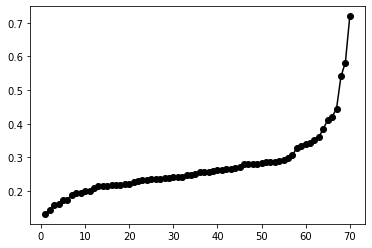

In [325]:
print(np.quantile(res.tolist(), [0,0.25,0.5,0.75,1]))
plt.plot(range(1, len(res)+1), sorted(res.tolist()), '-ok')

In [198]:
# df of DMSO vs VHL for each condition
d=pd.DataFrame(data=r.values(), index=r.keys(), columns=['ERCC pseudo-counts','var'])
d['Experiments']=d.index
d

,ERCC pseudo-counts,var,Experiments
MYB-dTAG-DMSO_1h,0.325573,0.075519,MYB-dTAG-DMSO_1h
MYB-dTAG-VHL_1h,0.288937,0.059352,MYB-dTAG-VHL_1h
MYB-dTAG-DMSO_2h,0.264546,0.043404,MYB-dTAG-DMSO_2h
MYB-dTAG-VHL_2h,0.267797,0.025024,MYB-dTAG-VHL_2h
MYB-dTAG-DMSO_4h,0.267105,0.038352,MYB-dTAG-DMSO_4h
MYB-dTAG-VHL_4h,0.257653,0.016197,MYB-dTAG-VHL_4h
MYB-dTAG-DMSO_8h,0.229240,0.023660,MYB-dTAG-DMSO_8h
MYB-dTAG-VHL_8h,0.241336,0.010505,MYB-dTAG-VHL_8h
MYB-dTAG-DMSO_12h,0.248811,0.052244,MYB-dTAG-DMSO_12h
MYB-dTAG-VHL_12h,0.253726,0.044261,MYB-dTAG-VHL_12h


In [205]:
# add time condition to df
time_cond = [x.split("_")[-1] for x in r.keys()]
d['time'] = time_cond

# add treatment to df
treatment = ["DMSO" if "DMSO" in x else "VHL" for x in r.keys()]
d["treatment"] = treatment

ERCC scaling factors
* VHL vs DMSO should be different
* protein level in VHL < DMSO: more ERCC transcripts in VHL than DMSO (less RNA transcripts)
* scaling factors: VHL > DMSO - ERCC counts/scaling factors in VHL should be higher

v1
Creating output directory: ../results/slamseq_MYB_degraded_timecourse_v1//plots/


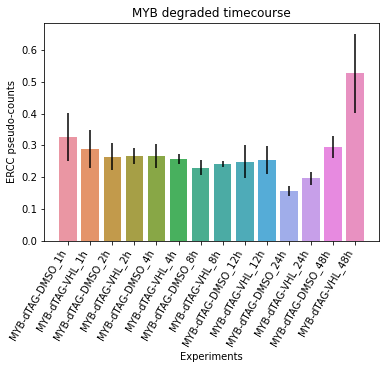

Saved to ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_scaling_fact_with_conf.pdf


In [282]:
version = project.replace("_", " ").split(" ")[-1]
print(version)
createDir(res_dir+"/plots/")

# barplot of DMSO vs VHL for each condition
sns.barplot(x="Experiments", y="ERCC pseudo-counts", data=d, ci=None, )
plt.errorbar(x=range(0,len(d)), y=d['ERCC pseudo-counts'],
             yerr=d['var'], fmt='none', ecolor="black")
plt.xticks(rotation=60, ha='right')
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf", bbox_inches="tight")
plt.show()
print("Saved to "+res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf")

In [283]:
def grouped_barplot(project, df, cat, subcat, val , err, save_file = None):
    'plot and save barchart grouped by time & colored by treatment'
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{}".format(gr), yerr=dfg[err].values)
    plt.xlabel(cat)
    plt.ylabel(val)
    plt.xticks(x, u)
    plt.title(project.replace("_", " ").split(" v")[0])
    plt.legend(title=subcat, loc="center left", bbox_to_anchor=(1.0, 0.5))
    
    if save_file is not None:
        plt.savefig(save_file, bbox_inches="tight")
        print("Saving to "+save_file)
        
    plt.show()

Saving to ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_scaling_fact_with_conf_grouped.pdf


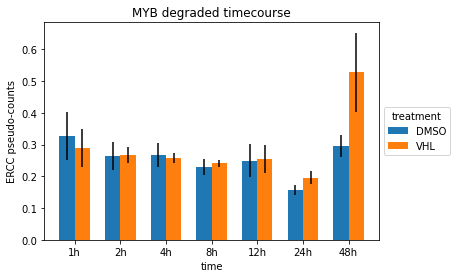

In [284]:
grouped_barplot(project, d, "time", "treatment", "ERCC pseudo-counts", "var", 
                save_file = res_dir+"plots/"+project+"_scaling_fact_with_conf_grouped.pdf")

__save average ERCC scaling factors__

In [285]:
d

,ERCC pseudo-counts,var,Experiments,time,treatment
MYB-dTAG-DMSO_1h,0.325573,0.075519,MYB-dTAG-DMSO_1h,1h,DMSO
MYB-dTAG-VHL_1h,0.288937,0.059352,MYB-dTAG-VHL_1h,1h,VHL
MYB-dTAG-DMSO_2h,0.264546,0.043404,MYB-dTAG-DMSO_2h,2h,DMSO
MYB-dTAG-VHL_2h,0.267797,0.025024,MYB-dTAG-VHL_2h,2h,VHL
MYB-dTAG-DMSO_4h,0.267105,0.038352,MYB-dTAG-DMSO_4h,4h,DMSO
MYB-dTAG-VHL_4h,0.257653,0.016197,MYB-dTAG-VHL_4h,4h,VHL
MYB-dTAG-DMSO_8h,0.229240,0.023660,MYB-dTAG-DMSO_8h,8h,DMSO
MYB-dTAG-VHL_8h,0.241336,0.010505,MYB-dTAG-VHL_8h,8h,VHL
MYB-dTAG-DMSO_12h,0.248811,0.052244,MYB-dTAG-DMSO_12h,12h,DMSO
MYB-dTAG-VHL_12h,0.253726,0.044261,MYB-dTAG-VHL_12h,12h,VHL


In [286]:
# save avg ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
d.to_csv(res_dir+project+"_scaling_factors_avg.csv", header=True, index=True)

## Saving the data in our bucket

In [326]:
print(project)

MYB_degraded_timecourse_v1


In [ ]:
! gsutil -m cp ../../data/slamseq_$project/fastqs/* gs://amlproject/RNA/slamseq/$project/fastqs/ 
! gsutil -m cp ../../data/slamseq_$project/res/map/* gs://amlproject/RNA/slamseq/$project/res/map/ 
! gsutil -m cp ../../data/slamseq_$project/res/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res/count/* gs://amlproject/RNA/slamseq/$project/res/count/

Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_R1_001.fastq.gz [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file:/

Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R2_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R2_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr393-MV411-RUNX1-dTAG-VHL_1h-r3_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr394-MV411-RUNX1-dTAG-VHL_1h-r4_R1_001.fa

Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr399-MV411-RUNX2-dTAG-VHL_1h-r1_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr399-MV411-RUNX2-dTAG-VHL_1h-r1_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Resuming upload for file://../../data/slamseq_4_degrons_v1/fastqs/mr399-MV411-RUNX2-dTAG-VHL_1h-r1_R2_001_val_2.fq.gz
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr400-MV411-RUNX2-dTAG-VHL_1h-r2_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Resuming upload for file://../../data/slamseq_4_degrons_v1/fastqs/mr400-MV411-RUNX2-dTAG-VHL_1h-r2_R1_001.fastq.gz
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr400-MV411-RUNX2-dTAG-VHL_1h-r2_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_4_degrons_v1/fastqs/mr400-MV411-RUNX2-dTAG-VHL_1h-r2_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file

# SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

## Make count files

In [330]:
project = project
res_folder = "res"
location = "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_MYB_degraded_timecourse_v1/res/count/


In [16]:
# remove genes that have very low counts
mincount_toremove=5

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

<li>readcounts: total counts of every transscript (output of slamdunk algorithm
<li>tccounts: t to c converted RNA transcripts

In [17]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 35 files:dict_keys(['mr387-MV411-RUNX1-dTAG-DMSO_1h-r1_tcount', 'mr388-MV411-RUNX1-dTAG-DMSO_1h-r2_tcount', 'mr389-MV411-RUNX1-dTAG-DMSO_1h-r3_tcount', 'mr390-MV411-RUNX1-dTAG-DMSO_1h-r4_tcount', 'mr391-MV411-RUNX1-dTAG-VHL_1h-r1_tcount', 'mr392-MV411-RUNX1-dTAG-VHL_1h-r2_tcount', 'mr393-MV411-RUNX1-dTAG-VHL_1h-r3_tcount', 'mr394-MV411-RUNX1-dTAG-VHL_1h-r4_tcount', 'mr395-MV411-RUNX2-dTAG-DMSO_1h-r1_tcount', 'mr396-MV411-RUNX2-dTAG-DMSO_1h-r2_tcount', 'mr397-MV411-RUNX2-dTAG-DMSO_1h-r3_tcount', 'mr398-MV411-RUNX2-dTAG-DMSO_1h-r4_tcount', 'mr399-MV411-RUNX2-dTAG-VHL_1h-r1_tcount', 'mr400-MV411-RUNX2-dTAG-VHL_1h-r2_tcount', 'mr401-MV411-RUNX2-dTAG-VHL_1h-r3_tcount', 'mr402-MV411-RUNX2-dTAG-VHL_1h-r4_tcount', 'mr403-MV411-SPI1-dTAG-DMSO_1h-r1_tcount', 'mr404-MV411-SPI1-dTAG-DMSO_1h-r2_tcount', 'mr405-MV411-SPI1-dTAG-DMSO_1h-r3_tcount', 'mr406-MV411-SPI1-dTAG-DMSO_1h-r4_tcount', 'mr407-MV411-SPI1-dTAG-DMSO_1h-r5_tcount', 'mr408-MV411-SPI1-dTAG-VHL_1h-r1_tcount', 'mr409-MV411-SPI1-dTA

Check for duplicate gene rows

In [331]:
def dedup_df_genes(df):
    ''' sum rows with the same gene index and remove duplicate '''
    if df.shape[0] != len(df.index.drop_duplicates()):
        print("Duplicate gene rows!")
        print("{} rows | {} unique genes".format(df.shape[0], len(df.index.drop_duplicates())))
        print("Summing of duplicate gene rows.")
        
    # sum duplicate rows, same row order
    duplicate_genes = df.index[df.index.duplicated()].tolist()
    df = df.groupby(df.index).sum().loc[df.index.drop_duplicates()]
    if df.shape[0] != len(df.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )
    
    return df, duplicate_genes

In [332]:
readcounts, duplicate_genes = dedup_df_genes(readcounts)
tccounts, duplicate_genes = dedup_df_genes(tccounts)

if readcounts.shape != tccounts.shape:
    raise ValueError("readcounts and tccounts not the same dimensions: {} | {}".format(readcounts.shape, tccounts.shape))

Duplicate gene rows!
18347 rows | 18305 unique genes
Summing of duplicate gene rows.
Duplicate gene rows!
18347 rows | 18305 unique genes
Summing of duplicate gene rows.


### make density plot

In [333]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)
createDir(res_dir)

../results/slamseq_MYB_degraded_timecourse_v1/


In [334]:
col = tccounts.columns.tolist() # sort cols
col.sort()
tccounts = tccounts[col]

In [335]:
col = readcounts.columns.tolist() # sort cols
col.sort()
readcounts = readcounts[col]

In [336]:
print(readcounts.shape)
readcounts.iloc[:2]

(18305, 70)


,mr422-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr423-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr424-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr425-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr426-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr427-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr428-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr429-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr430-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr431-MV411-MYB-dTAG-VHL_1h-r5_tcount,...,mr482-MV411-MYB-dTAG-DMSO_48h-r1_tcount,mr483-MV411-MYB-dTAG-DMSO_48h-r2_tcount,mr484-MV411-MYB-dTAG-DMSO_48h-r3_tcount,mr485-MV411-MYB-dTAG-DMSO_48h-r4_tcount,mr486-MV411-MYB-dTAG-DMSO_48h-r5_tcount,mr487-MV411-MYB-dTAG-VHL_48h-r1_tcount,mr488-MV411-MYB-dTAG-VHL_48h-r2_tcount,mr489-MV411-MYB-dTAG-VHL_48h-r3_tcount,mr490-MV411-MYB-dTAG-VHL_48h-r4_tcount,mr491-MV411-MYB-dTAG-VHL_48h-r5_tcount
A1BG,2,1,2,0,0,3,3,2,0,2,...,0,1,1,0,3,1,4,4,1,3
A2MP1,6,1,3,6,4,0,1,6,11,2,...,0,0,2,3,0,3,1,2,1,4


read counts that are t $\rightarrow$ c converted (actively transcribed)
* most at 0 = most are not transcribed
* a lot at 1 or everything at 0 is weird

18041


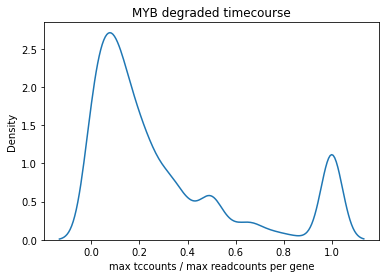

In [388]:
# what is the average of highly transcribed genes
# tccounts/readcounts where sum of readcounts in all samples > 30 
a = tccounts[readcounts.sum(1)>30] / readcounts[readcounts.sum(1)>30]
a = a.fillna(0)
a = a.max(1).tolist() # max val per gene
a.sort()
print(len(a))
sns.kdeplot(a)
plt.xlabel("max tccounts / max readcounts per gene")
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+'plots/'+project+'_tccounts_readcounts_density.pdf', dpi=300, bbox_inches="tight")
plt.show()

In [338]:
np.median(a)

0.1724137931034483

In [339]:
# Save counts to csv
counts_file_prefix = project+'_'+str(minvar_toremove)+'_'+str(mincount_toremove)

readcounts.to_csv(res_dir+counts_file_prefix+"_readcounts.csv",index=True, index_label="GENE")
print("Saved readcounts to: {}".format(res_dir+counts_file_prefix+"_readcounts.csv"))

tccounts.to_csv(res_dir+counts_file_prefix+"_tccounts.csv",index=True, index_label="GENE")
print("Saved tccounts to: {}".format(res_dir+counts_file_prefix+"_tccounts.csv"))

Saved readcounts to: ../results/slamseq_MYB_degraded_timecourse_v1/MYB_degraded_timecourse_v1_0_5_readcounts.csv
Saved tccounts to: ../results/slamseq_MYB_degraded_timecourse_v1/MYB_degraded_timecourse_v1_0_5_tccounts.csv


### make more df (mean, median, etc.)

In [340]:
readcounts.iloc[:1]

,mr422-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr423-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr424-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr425-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr426-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr427-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr428-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr429-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr430-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr431-MV411-MYB-dTAG-VHL_1h-r5_tcount,...,mr482-MV411-MYB-dTAG-DMSO_48h-r1_tcount,mr483-MV411-MYB-dTAG-DMSO_48h-r2_tcount,mr484-MV411-MYB-dTAG-DMSO_48h-r3_tcount,mr485-MV411-MYB-dTAG-DMSO_48h-r4_tcount,mr486-MV411-MYB-dTAG-DMSO_48h-r5_tcount,mr487-MV411-MYB-dTAG-VHL_48h-r1_tcount,mr488-MV411-MYB-dTAG-VHL_48h-r2_tcount,mr489-MV411-MYB-dTAG-VHL_48h-r3_tcount,mr490-MV411-MYB-dTAG-VHL_48h-r4_tcount,mr491-MV411-MYB-dTAG-VHL_48h-r5_tcount
A1BG,2,1,2,0,0,3,3,2,0,2,...,0,1,1,0,3,1,4,4,1,3


In [341]:
print("Genes with highest read counts per sample.")
for column in readcounts:
    print(column.split("MV411-")[1].split("_")[0] +": "+ str(readcounts[column].idxmax()))

Genes with highest read counts per sample.
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: MALAT1
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-DMSO: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-VHL: RPL13AP5
MYB-dTAG-DMSO: RPL1

In [344]:
readcounts.idxmax().value_counts()

RPL13AP5    66
MALAT1       4
dtype: int64

In [346]:
print(set([i.split('-')[-2] for i in tccounts.columns]))
print(tccounts.columns[0].split('-', 1))
print(tccounts.columns[0].split('-', 1)[-1].rpartition("-")[0])
set([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])

{'VHL_1h', 'DMSO_2h', 'VHL_8h', 'DMSO_12h', 'VHL_24h', 'VHL_12h', 'VHL_48h', 'DMSO_24h', 'DMSO_1h', 'VHL_2h', 'DMSO_48h', 'DMSO_8h', 'VHL_4h', 'DMSO_4h'}
['mr422', 'MV411-MYB-dTAG-DMSO_1h-r1_tcount']
MV411-MYB-dTAG-DMSO_1h


{'MV411-MYB-dTAG-DMSO_12h',
 'MV411-MYB-dTAG-DMSO_1h',
 'MV411-MYB-dTAG-DMSO_24h',
 'MV411-MYB-dTAG-DMSO_2h',
 'MV411-MYB-dTAG-DMSO_48h',
 'MV411-MYB-dTAG-DMSO_4h',
 'MV411-MYB-dTAG-DMSO_8h',
 'MV411-MYB-dTAG-VHL_12h',
 'MV411-MYB-dTAG-VHL_1h',
 'MV411-MYB-dTAG-VHL_24h',
 'MV411-MYB-dTAG-VHL_2h',
 'MV411-MYB-dTAG-VHL_48h',
 'MV411-MYB-dTAG-VHL_4h',
 'MV411-MYB-dTAG-VHL_8h'}

In [348]:
# get mean counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].mean(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].mean(1)

# save mean counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_mean_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_mean_readcounts.csv", index=True, index_label="GENE")

MV411-MYB-dTAG-DMSO_1h
MV411-MYB-dTAG-VHL_1h
MV411-MYB-dTAG-DMSO_2h
MV411-MYB-dTAG-VHL_2h
MV411-MYB-dTAG-DMSO_4h
MV411-MYB-dTAG-VHL_4h
MV411-MYB-dTAG-DMSO_8h
MV411-MYB-dTAG-VHL_8h
MV411-MYB-dTAG-DMSO_12h
MV411-MYB-dTAG-VHL_12h
MV411-MYB-dTAG-DMSO_24h
MV411-MYB-dTAG-VHL_24h
MV411-MYB-dTAG-DMSO_48h
MV411-MYB-dTAG-VHL_48h


In [349]:
# get median counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].median(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].median(1)

# save median counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_median_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_median_readcounts.csv", index=True, index_label="GENE")

MV411-MYB-dTAG-DMSO_1h
MV411-MYB-dTAG-VHL_1h
MV411-MYB-dTAG-DMSO_2h
MV411-MYB-dTAG-VHL_2h
MV411-MYB-dTAG-DMSO_4h
MV411-MYB-dTAG-VHL_4h
MV411-MYB-dTAG-DMSO_8h
MV411-MYB-dTAG-VHL_8h
MV411-MYB-dTAG-DMSO_12h
MV411-MYB-dTAG-VHL_12h
MV411-MYB-dTAG-DMSO_24h
MV411-MYB-dTAG-VHL_24h
MV411-MYB-dTAG-DMSO_48h
MV411-MYB-dTAG-VHL_48h


In [350]:
(tccounts/readcounts).fillna(0).iloc[:2]

,mr422-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr423-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr424-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr425-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr426-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr427-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr428-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr429-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr430-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr431-MV411-MYB-dTAG-VHL_1h-r5_tcount,...,mr482-MV411-MYB-dTAG-DMSO_48h-r1_tcount,mr483-MV411-MYB-dTAG-DMSO_48h-r2_tcount,mr484-MV411-MYB-dTAG-DMSO_48h-r3_tcount,mr485-MV411-MYB-dTAG-DMSO_48h-r4_tcount,mr486-MV411-MYB-dTAG-DMSO_48h-r5_tcount,mr487-MV411-MYB-dTAG-VHL_48h-r1_tcount,mr488-MV411-MYB-dTAG-VHL_48h-r2_tcount,mr489-MV411-MYB-dTAG-VHL_48h-r3_tcount,mr490-MV411-MYB-dTAG-VHL_48h-r4_tcount,mr491-MV411-MYB-dTAG-VHL_48h-r5_tcount
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2MP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [351]:
# Save tccounts/readcounts file
(tccounts/readcounts).fillna(0).to_csv(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv")
print("Saved tccounts/readcounts to: {}".format(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv"))

Saved tccounts/readcounts to: ../results/slamseq_MYB_degraded_timecourse_v1/MYB_degraded_timecourse_v1_0_5_tccounts_per_readcounts.csv


## Look at similarity accross replicates

we have some outliers, else it seems to make some sense and on average, to be extremelly similar!

In [353]:
createDir("../results/slamseq_"+project+"/plots/")

In [377]:
[i.split('_tc', 1)[0].split("-", 4)[-1] for i in tccounts.columns[:5]]

['DMSO_1h-r1', 'DMSO_1h-r2', 'DMSO_1h-r3', 'DMSO_1h-r4', 'DMSO_1h-r5']

In [355]:
[i.rpartition("_")[0] for i in tccounts.columns.tolist()] # name without _tccount
#tccounts.columns[0].split('-', 1)[-1].rpartition("-")[0]
[i.split("-")[-2] for i in tccounts.columns] # conditions

['DMSO_1h',
 'DMSO_1h',
 'DMSO_1h',
 'DMSO_1h',
 'DMSO_1h',
 'VHL_1h',
 'VHL_1h',
 'VHL_1h',
 'VHL_1h',
 'VHL_1h',
 'DMSO_2h',
 'DMSO_2h',
 'DMSO_2h',
 'DMSO_2h',
 'DMSO_2h',
 'VHL_2h',
 'VHL_2h',
 'VHL_2h',
 'VHL_2h',
 'VHL_2h',
 'DMSO_4h',
 'DMSO_4h',
 'DMSO_4h',
 'DMSO_4h',
 'DMSO_4h',
 'VHL_4h',
 'VHL_4h',
 'VHL_4h',
 'VHL_4h',
 'VHL_4h',
 'DMSO_8h',
 'DMSO_8h',
 'DMSO_8h',
 'DMSO_8h',
 'DMSO_8h',
 'VHL_8h',
 'VHL_8h',
 'VHL_8h',
 'VHL_8h',
 'VHL_8h',
 'DMSO_12h',
 'DMSO_12h',
 'DMSO_12h',
 'DMSO_12h',
 'DMSO_12h',
 'VHL_12h',
 'VHL_12h',
 'VHL_12h',
 'VHL_12h',
 'VHL_12h',
 'DMSO_24h',
 'DMSO_24h',
 'DMSO_24h',
 'DMSO_24h',
 'DMSO_24h',
 'VHL_24h',
 'VHL_24h',
 'VHL_24h',
 'VHL_24h',
 'VHL_24h',
 'DMSO_48h',
 'DMSO_48h',
 'DMSO_48h',
 'DMSO_48h',
 'DMSO_48h',
 'VHL_48h',
 'VHL_48h',
 'VHL_48h',
 'VHL_48h',
 'VHL_48h']

### save plots to pdf

In [364]:
tccounts.iloc[:,:20].columns.tolist()

['mr422-MV411-MYB-dTAG-DMSO_1h-r1_tcount',
 'mr423-MV411-MYB-dTAG-DMSO_1h-r2_tcount',
 'mr424-MV411-MYB-dTAG-DMSO_1h-r3_tcount',
 'mr425-MV411-MYB-dTAG-DMSO_1h-r4_tcount',
 'mr426-MV411-MYB-dTAG-DMSO_1h-r5_tcount',
 'mr427-MV411-MYB-dTAG-VHL_1h-r1_tcount',
 'mr428-MV411-MYB-dTAG-VHL_1h-r2_tcount',
 'mr429-MV411-MYB-dTAG-VHL_1h-r3_tcount',
 'mr430-MV411-MYB-dTAG-VHL_1h-r4_tcount',
 'mr431-MV411-MYB-dTAG-VHL_1h-r5_tcount',
 'mr432-MV411-MYB-dTAG-DMSO_2h-r1_tcount',
 'mr433-MV411-MYB-dTAG-DMSO_2h-r2_tcount',
 'mr434-MV411-MYB-dTAG-DMSO_2h-r3_tcount',
 'mr435-MV411-MYB-dTAG-DMSO_2h-r4_tcount',
 'mr436-MV411-MYB-dTAG-DMSO_2h-r5_tcount',
 'mr437-MV411-MYB-dTAG-VHL_2h-r1_tcount',
 'mr438-MV411-MYB-dTAG-VHL_2h-r2_tcount',
 'mr439-MV411-MYB-dTAG-VHL_2h-r3_tcount',
 'mr440-MV411-MYB-dTAG-VHL_2h-r4_tcount',
 'mr441-MV411-MYB-dTAG-VHL_2h-r5_tcount']

Replicate similarity plot saved to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_similarity_replicates_sorted_tccounts.pdf


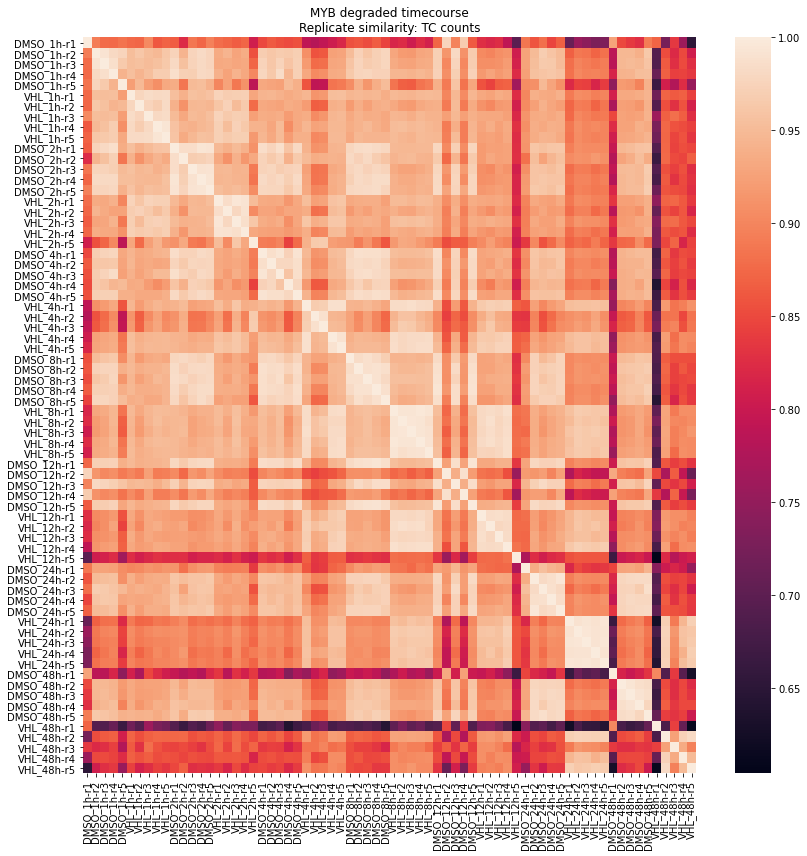

In [391]:
%matplotlib inline
import matplotlib.font_manager

font_settings = {
    "family" : "sans-serif",
    #"sans-serif" : "Arial",
    "size" : 10
}
plt.rc("font", **font_settings)

# tccounts
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(tccounts.corr(), #tccounts.iloc[:,30:50].corr(), 
            # condition w/o rep label
            xticklabels=[i.split('_tc', 1)[0].split("-", 4)[-1] for i in tccounts.columns],
            yticklabels=[i.split('_tc', 1)[0].split("-", 4)[-1] for i in tccounts.columns],
            # condition w/ rep label
            #xticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            #yticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            ax=ax, cmap="rocket")#, vmin=0.9, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: TC counts")
plt.tight_layout()

#plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_tccounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_tccounts.pdf'))

Replicate similarity plot saved to: ../results/slamseq_MYB_degraded_timecourse_v1/plots/MYB_degraded_timecourse_v1_similarity_replicates_sorted_readcounts.pdf


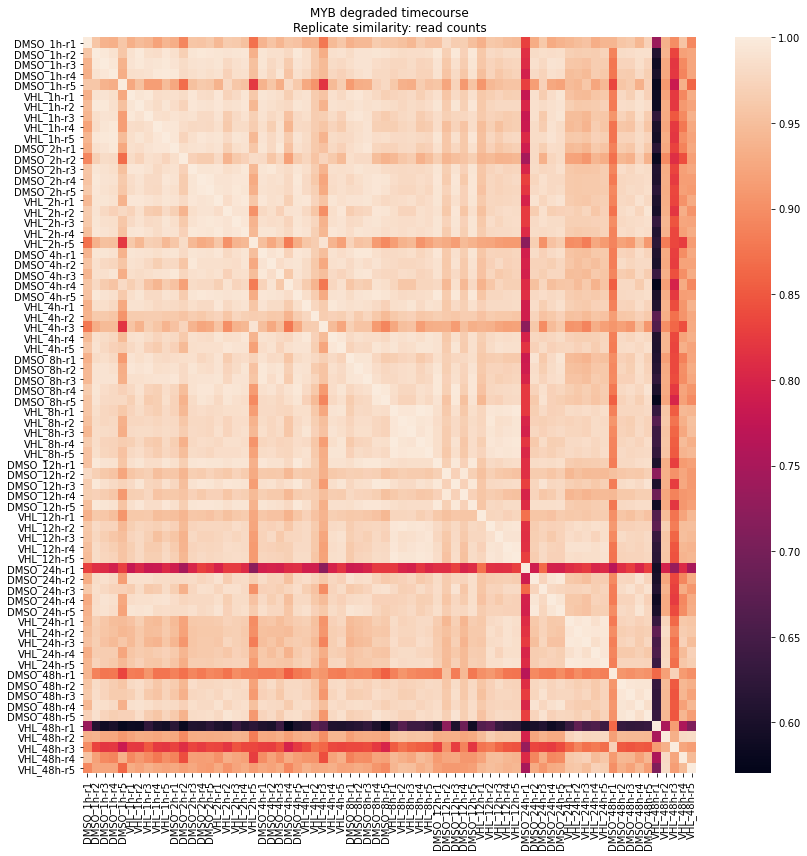

In [387]:
%matplotlib inline

# readcounts
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(readcounts.corr(), 
            # condition w/ replicate
            xticklabels=[i.split('_tc', 1)[0].split("-", 4)[-1] for i in readcounts.columns],
            yticklabels=[i.split('_tc', 1)[0].split("-", 4)[-1] for i in readcounts.columns],
            ax=ax)#, cmap=cmp_cylin), vmin=0.985, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: read counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_readcounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_readcounts.pdf'))

# DESEQ Analysis

In [634]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)

../results/slamseq_MYB_degraded_timecourse_v1/


In [393]:
readcounts.iloc[:3]

,mr422-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr423-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr424-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr425-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr426-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr427-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr428-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr429-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr430-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr431-MV411-MYB-dTAG-VHL_1h-r5_tcount,...,mr482-MV411-MYB-dTAG-DMSO_48h-r1_tcount,mr483-MV411-MYB-dTAG-DMSO_48h-r2_tcount,mr484-MV411-MYB-dTAG-DMSO_48h-r3_tcount,mr485-MV411-MYB-dTAG-DMSO_48h-r4_tcount,mr486-MV411-MYB-dTAG-DMSO_48h-r5_tcount,mr487-MV411-MYB-dTAG-VHL_48h-r1_tcount,mr488-MV411-MYB-dTAG-VHL_48h-r2_tcount,mr489-MV411-MYB-dTAG-VHL_48h-r3_tcount,mr490-MV411-MYB-dTAG-VHL_48h-r4_tcount,mr491-MV411-MYB-dTAG-VHL_48h-r5_tcount
A1BG,2,1,2,0,0,3,3,2,0,2,...,0,1,1,0,3,1,4,4,1,3
A2MP1,6,1,3,6,4,0,1,6,11,2,...,0,0,2,3,0,3,1,2,1,4
NAT1,285,177,181,258,69,206,159,212,325,276,...,184,165,198,305,201,70,145,167,115,163


In [394]:
readcounts["genes"] = readcounts.index # make genes col
readcounts = readcounts.reset_index(drop=True)

tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

In [395]:
readcounts.iloc[:1]

,mr422-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr423-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr424-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr425-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr426-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr427-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr428-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr429-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr430-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr431-MV411-MYB-dTAG-VHL_1h-r5_tcount,...,mr483-MV411-MYB-dTAG-DMSO_48h-r2_tcount,mr484-MV411-MYB-dTAG-DMSO_48h-r3_tcount,mr485-MV411-MYB-dTAG-DMSO_48h-r4_tcount,mr486-MV411-MYB-dTAG-DMSO_48h-r5_tcount,mr487-MV411-MYB-dTAG-VHL_48h-r1_tcount,mr488-MV411-MYB-dTAG-VHL_48h-r2_tcount,mr489-MV411-MYB-dTAG-VHL_48h-r3_tcount,mr490-MV411-MYB-dTAG-VHL_48h-r4_tcount,mr491-MV411-MYB-dTAG-VHL_48h-r5_tcount,genes
0,2,1,2,0,0,3,3,2,0,2,...,1,1,0,3,1,4,4,1,3,A1BG


In [396]:
tccounts.iloc[:1]

,mr422-MV411-MYB-dTAG-DMSO_1h-r1_tcount,mr423-MV411-MYB-dTAG-DMSO_1h-r2_tcount,mr424-MV411-MYB-dTAG-DMSO_1h-r3_tcount,mr425-MV411-MYB-dTAG-DMSO_1h-r4_tcount,mr426-MV411-MYB-dTAG-DMSO_1h-r5_tcount,mr427-MV411-MYB-dTAG-VHL_1h-r1_tcount,mr428-MV411-MYB-dTAG-VHL_1h-r2_tcount,mr429-MV411-MYB-dTAG-VHL_1h-r3_tcount,mr430-MV411-MYB-dTAG-VHL_1h-r4_tcount,mr431-MV411-MYB-dTAG-VHL_1h-r5_tcount,...,mr483-MV411-MYB-dTAG-DMSO_48h-r2_tcount,mr484-MV411-MYB-dTAG-DMSO_48h-r3_tcount,mr485-MV411-MYB-dTAG-DMSO_48h-r4_tcount,mr486-MV411-MYB-dTAG-DMSO_48h-r5_tcount,mr487-MV411-MYB-dTAG-VHL_48h-r1_tcount,mr488-MV411-MYB-dTAG-VHL_48h-r2_tcount,mr489-MV411-MYB-dTAG-VHL_48h-r3_tcount,mr490-MV411-MYB-dTAG-VHL_48h-r4_tcount,mr491-MV411-MYB-dTAG-VHL_48h-r5_tcount,genes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A1BG


__Exclude replicates__
* 1hr DMSO rep 1
* 12hr VHL rep 5
* 48hr DMSO rep 1
* 48hr VHL rep 1

__ERCC normalization__
* 1hr - no
* 2hr - no
* 4hr - no
* 8hr - no
* 12hr - no
* 24hr - yes
* 48hr - yes

In [497]:
drop_samples = ["DMSO_1h-r1", "VHL_12h-r5", "DMSO_48h-r1", "VHL_48h-r1"]
ERCC_norm_times = ["24h", "48h"]

In [498]:
# col info
cols = tccounts.columns[:-1]
experiments = [x.split("-", 1)[1].rsplit("-", 1)[0] for x in cols]
conds = [x.split("-")[-2] for x in cols]
time = [x.split("_")[-1] for x in conds]
treatment = [x.split("_")[0] for x in conds]
rep = [x.split("_")[-2].split("-")[-1] for x in cols]
drop = [True if any(sample in x for sample in drop_samples) else False for x in cols]
ERCC_norm = [True if x in ERCC_norm_times else False for x in time]

# experimental design
exp_design = pd.DataFrame(list(zip(cols, experiments, conds, time, treatment, rep, drop, ERCC_norm)), 
                          columns=["col", "experiment", "cond", "time", "treatment", "rep", "drop", "ERCC_norm"])

In [499]:
exp_design.head()

,col,experiment,cond,time,treatment,rep,drop,ERCC_norm
0,mr422-MV411-MYB-dTAG-DMSO_1h-r1_tcount,MV411-MYB-dTAG-DMSO_1h,DMSO_1h,1h,DMSO,r1,True,False
1,mr423-MV411-MYB-dTAG-DMSO_1h-r2_tcount,MV411-MYB-dTAG-DMSO_1h,DMSO_1h,1h,DMSO,r2,False,False
2,mr424-MV411-MYB-dTAG-DMSO_1h-r3_tcount,MV411-MYB-dTAG-DMSO_1h,DMSO_1h,1h,DMSO,r3,False,False
3,mr425-MV411-MYB-dTAG-DMSO_1h-r4_tcount,MV411-MYB-dTAG-DMSO_1h,DMSO_1h,1h,DMSO,r4,False,False
4,mr426-MV411-MYB-dTAG-DMSO_1h-r5_tcount,MV411-MYB-dTAG-DMSO_1h,DMSO_1h,1h,DMSO,r5,False,False


## MYB 1hr

### make design matrix

In [623]:
# MYB dTAG 1h
gene = "MYB"
version = "v1"
var_name = "time"
var = "1h"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [624]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [625]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

DMSO_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "DMSO") and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

VHL_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "VHL") and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [626]:
# RUNX1 dTAG (all columns)
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=["DMSO","VHL"], 
                      data=np.array([DMSO_cols, VHL_cols], dtype=bool).T)

In [627]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [628]:
scaling="ERCCsamplewise"

#### make DESeq object

In [629]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [630]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [631]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [635]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr423-MV411-MYB-dTAG-DMSO_1h-r2_filtered.bam    0.411434
ERCC_mr424-MV411-MYB-dTAG-DMSO_1h-r3_filtered.bam    0.242111
ERCC_mr425-MV411-MYB-dTAG-DMSO_1h-r4_filtered.bam    0.289384
ERCC_mr426-MV411-MYB-dTAG-DMSO_1h-r5_filtered.bam    0.264057
ERCC_mr427-MV411-MYB-dTAG-VHL_1h-r1_filtered.bam     0.385407
ERCC_mr428-MV411-MYB-dTAG-VHL_1h-r2_filtered.bam     0.306924
ERCC_mr429-MV411-MYB-dTAG-VHL_1h-r3_filtered.bam     0.297752
ERCC_mr430-MV411-MYB-dTAG-VHL_1h-r4_filtered.bam     0.214893
ERCC_mr431-MV411-MYB-dTAG-VHL_1h-r5_filtered.bam     0.239709
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [636]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [637]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [638]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.93 s, sys: 1.97 s, total: 10.9 s
Wall time: 6.79 s


In [639]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.36 s, sys: 1.91 s, total: 10.3 s
Wall time: 6.1 s


#### save DESeq results

In [640]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [641]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_1h_ERCCsamplewise_0_5_deseq_tccounts.csv


In [642]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_1h_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [643]:
scaling = None

#### make DESeq object

In [644]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [645]:
# readcounts DESeq gene object
# just var data
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [646]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [647]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.26 s, sys: 1.77 s, total: 10 s
Wall time: 6.3 s


In [648]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 9.12 s, sys: 2.13 s, total: 11.2 s
Wall time: 6.67 s


#### save DESeq results

In [649]:
# check all genes are in output
if not readcounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not readcounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [650]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_1h_0_5_deseq_tccounts.csv


In [651]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_1h_0_5_deseq_readcounts.csv


## MYB 2hr

### make design matrix

In [652]:
# MYB dTAG 2h
gene = "MYB"
version = "v1"
var_name = "time"
var = "2h"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [653]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [654]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

DMSO_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "DMSO") and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

VHL_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "VHL") and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [655]:
# RUNX1 dTAG (all columns)
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=["DMSO","VHL"], 
                      data=np.array([DMSO_cols, VHL_cols], dtype=bool).T)

In [656]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [661]:
scaling="ERCCsamplewise"

#### make DESeq object

In [662]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [663]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [664]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [665]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
print(len(res))
res

10


0
ERCC_mr432-MV411-MYB-dTAG-DMSO_2h-r1_filtered.bam    0.227173
ERCC_mr433-MV411-MYB-dTAG-DMSO_2h-r2_filtered.bam    0.218944
ERCC_mr434-MV411-MYB-dTAG-DMSO_2h-r3_filtered.bam    0.339323
ERCC_mr435-MV411-MYB-dTAG-DMSO_2h-r4_filtered.bam    0.281253
ERCC_mr436-MV411-MYB-dTAG-DMSO_2h-r5_filtered.bam    0.256038
ERCC_mr437-MV411-MYB-dTAG-VHL_2h-r1_filtered.bam     0.279720
ERCC_mr438-MV411-MYB-dTAG-VHL_2h-r2_filtered.bam     0.285925
ERCC_mr439-MV411-MYB-dTAG-VHL_2h-r3_filtered.bam     0.265613
ERCC_mr440-MV411-MYB-dTAG-VHL_2h-r4_filtered.bam     0.287533
ERCC_mr441-MV411-MYB-dTAG-VHL_2h-r5_filtered.bam     0.220194
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [666]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [667]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [668]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.67 s, sys: 1.7 s, total: 9.38 s
Wall time: 5.75 s


In [669]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 9.12 s, sys: 2.06 s, total: 11.2 s
Wall time: 6.72 s


#### save DESeq results

In [670]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [671]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_2h_ERCCsamplewise_0_5_deseq_tccounts.csv


In [672]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_2h_ERCCsamplewise_0_5_deseq_readcounts.csv


### Unscaled

In [673]:
scaling = None

#### make DESeq object

In [674]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [675]:
# readcounts DESeq gene object
# just var data
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [676]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [677]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.59 s, sys: 1.65 s, total: 9.24 s
Wall time: 5.7 s


In [678]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 9 s, sys: 2.02 s, total: 11 s
Wall time: 6.77 s


#### save DESeq results

In [679]:
# check all genes are in output
if not readcounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not readcounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [680]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_2h_0_5_deseq_tccounts.csv


In [681]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_2h_0_5_deseq_readcounts.csv


In [684]:
print(resGene_tc.shape)
resGene_tc.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,45.190251,0.273015,0.313194,-0.871711,0.383366,0.735587,NAT1,NAT1
3,44.977775,-0.624456,0.290171,2.152025,0.031395,0.188833,AAMP,AAMP
4,69.579384,0.505409,0.166225,-3.040510,0.002362,0.027596,AARS1,AARS1


In [682]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.186268,0.721365,1.435567,-0.502495,0.615319,NaN,A1BG,A1BG
1,2.746355,0.950378,0.888944,-1.069110,0.285020,NaN,A2MP1,A2MP1
2,310.018994,0.059052,0.171175,-0.344980,0.730109,0.966961,NAT1,NAT1
3,1110.545906,-0.185126,0.189223,0.978350,0.327901,0.834637,AAMP,AAMP
4,634.134786,0.104827,0.096690,-1.084156,0.278296,0.799028,AARS1,AARS1


## MYB 4hr

### make design matrix

In [685]:
# MYB dTAG 4h
gene = "MYB"
version = "v1"
var_name = "time"
var = "4h"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [686]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [687]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

DMSO_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "DMSO") and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

VHL_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "VHL") and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [688]:
# RUNX1 dTAG (all columns)
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=["DMSO","VHL"], 
                      data=np.array([DMSO_cols, VHL_cols], dtype=bool).T)

In [689]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [690]:
scaling="ERCCsamplewise"

#### make DESeq object

In [691]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [692]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [693]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [694]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
print(len(res))
res

10


0
ERCC_mr442-MV411-MYB-dTAG-DMSO_4h-r1_filtered.bam    0.232728
ERCC_mr443-MV411-MYB-dTAG-DMSO_4h-r2_filtered.bam    0.328421
ERCC_mr444-MV411-MYB-dTAG-DMSO_4h-r3_filtered.bam    0.220414
ERCC_mr445-MV411-MYB-dTAG-DMSO_4h-r4_filtered.bam    0.281330
ERCC_mr446-MV411-MYB-dTAG-DMSO_4h-r5_filtered.bam    0.272633
ERCC_mr447-MV411-MYB-dTAG-VHL_4h-r1_filtered.bam     0.265445
ERCC_mr448-MV411-MYB-dTAG-VHL_4h-r2_filtered.bam     0.264261
ERCC_mr449-MV411-MYB-dTAG-VHL_4h-r3_filtered.bam     0.235749
ERCC_mr450-MV411-MYB-dTAG-VHL_4h-r4_filtered.bam     0.242705
ERCC_mr451-MV411-MYB-dTAG-VHL_4h-r5_filtered.bam     0.280104
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [695]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [696]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [697]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.75 s, sys: 1.7 s, total: 9.45 s
Wall time: 5.82 s


In [698]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.42 s, sys: 2.04 s, total: 10.5 s
Wall time: 6.32 s


#### save DESeq results

In [699]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [700]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_4h_ERCCsamplewise_0_5_deseq_tccounts.csv


In [701]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_4h_ERCCsamplewise_0_5_deseq_readcounts.csv


In [702]:
print(resGene_tc.shape)
resGene_tc.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,26.414527,0.690513,0.351334,-1.965404,0.049367,0.162056,NAT1,NAT1
3,21.215665,-0.632553,0.325720,1.942013,0.052135,0.168089,AAMP,AAMP
4,31.465591,0.300500,0.255269,-1.177190,0.239120,0.448081,AARS1,AARS1


In [703]:
print(resGene_read.shape)
resGene_read.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.121765,-0.540574,3.158718,0.171137,0.864116,NaN,A1BG,A1BG
1,0.366055,0.626279,2.337053,-0.267978,0.788716,NaN,A2MP1,A2MP1
2,291.711338,0.781437,0.183985,-4.247277,0.000022,0.000350,NAT1,NAT1
3,746.516641,-0.327172,0.178182,1.836166,0.066333,0.188107,AAMP,AAMP
4,501.317477,0.217266,0.111862,-1.942265,0.052105,0.159177,AARS1,AARS1


### Unscaled

In [704]:
scaling = None

#### make DESeq object

In [705]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [706]:
# readcounts DESeq gene object
# just var data
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [707]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [708]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.44 s, sys: 1.77 s, total: 9.21 s
Wall time: 5.67 s


In [709]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.2 s, sys: 2.06 s, total: 10.3 s
Wall time: 6.21 s


#### save DESeq results

In [710]:
# check all genes are in output
if not readcounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not readcounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [711]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_4h_0_5_deseq_tccounts.csv


In [712]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_4h_0_5_deseq_readcounts.csv


In [713]:
print(resGene_tc.shape)
resGene_tc.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,25.821671,0.639648,0.350121,-1.826935,0.067710,0.203726,NAT1,NAT1
3,20.899280,-0.683553,0.322731,2.118027,0.034173,0.127981,AAMP,AAMP
4,30.849996,0.252953,0.254973,-0.992078,0.321159,0.541330,AARS1,AARS1


In [714]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.121765,-0.595423,3.158718,0.188501,0.850484,NaN,A1BG,A1BG
1,0.353852,0.552956,2.360917,-0.234212,0.814820,NaN,A2MP1,A2MP1
2,283.610998,0.718031,0.173124,-4.147488,0.000034,0.000430,NAT1,NAT1
3,734.640773,-0.379684,0.179910,2.110406,0.034823,0.113494,AAMP,AAMP
4,490.817851,0.162250,0.096971,-1.673173,0.094293,0.228096,AARS1,AARS1


## MYB 8hr

### make design matrix

In [715]:
# MYB dTAG 8h
gene = "MYB"
version = "v1"
var_name = "time"
var = "8h"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [716]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [717]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

DMSO_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "DMSO") and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

VHL_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "VHL") and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [718]:
# RUNX1 dTAG (all columns)
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=["DMSO","VHL"], 
                      data=np.array([DMSO_cols, VHL_cols], dtype=bool).T)

In [719]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [720]:
scaling="ERCCsamplewise"

#### make DESeq object

In [721]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [722]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [723]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [724]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
print(len(res))
res

10


0
ERCC_mr452-MV411-MYB-dTAG-DMSO_8h-r1_filtered.bam    0.258144
ERCC_mr453-MV411-MYB-dTAG-DMSO_8h-r2_filtered.bam    0.234804
ERCC_mr454-MV411-MYB-dTAG-DMSO_8h-r3_filtered.bam    0.208459
ERCC_mr455-MV411-MYB-dTAG-DMSO_8h-r4_filtered.bam    0.248922
ERCC_mr456-MV411-MYB-dTAG-DMSO_8h-r5_filtered.bam    0.195871
ERCC_mr457-MV411-MYB-dTAG-VHL_8h-r1_filtered.bam     0.242670
ERCC_mr458-MV411-MYB-dTAG-VHL_8h-r2_filtered.bam     0.240105
ERCC_mr459-MV411-MYB-dTAG-VHL_8h-r3_filtered.bam     0.229044
ERCC_mr460-MV411-MYB-dTAG-VHL_8h-r4_filtered.bam     0.234720
ERCC_mr461-MV411-MYB-dTAG-VHL_8h-r5_filtered.bam     0.260140
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [725]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [726]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [727]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.09 s, sys: 1.81 s, total: 9.9 s
Wall time: 6.15 s


In [728]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.17 s, sys: 1.85 s, total: 10 s
Wall time: 6.03 s


#### save DESeq results

In [729]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [730]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_8h_ERCCsamplewise_0_5_deseq_tccounts.csv


In [731]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_8h_ERCCsamplewise_0_5_deseq_readcounts.csv


In [732]:
print(resGene_tc.shape)
resGene_tc.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,28.522395,-0.240170,0.236283,1.016451,0.309415,0.576681,NAT1,NAT1
3,24.540796,0.023796,0.246608,-0.096492,0.923130,0.973011,AAMP,AAMP
4,36.429059,-0.330999,0.217694,1.520481,0.128390,0.339165,AARS1,AARS1


In [733]:
print(resGene_read.shape)
resGene_read.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.451699,1.183427,1.771724,-0.667952,0.504164,NaN,A1BG,A1BG
1,0.631889,-2.186740,1.627883,1.343303,0.179174,NaN,A2MP1,A2MP1
2,201.906879,-0.336007,0.163372,2.056702,0.039715,0.108268,NAT1,NAT1
3,693.698384,-0.386621,0.139597,2.769545,0.005613,0.022008,AAMP,AAMP
4,510.823587,0.111244,0.075850,-1.466625,0.142478,0.288559,AARS1,AARS1


### Unscaled

In [734]:
scaling = None

#### make DESeq object

In [735]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [736]:
# readcounts DESeq gene object
# just var data
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [737]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [738]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.66 s, sys: 1.72 s, total: 9.38 s
Wall time: 5.68 s


In [739]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 9.07 s, sys: 1.99 s, total: 11.1 s
Wall time: 6.75 s


#### save DESeq results

In [740]:
# check all genes are in output
if not readcounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not readcounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [741]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_8h_0_5_deseq_tccounts.csv


In [742]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_8h_0_5_deseq_readcounts.csv


In [743]:
print(resGene_tc.shape)
resGene_tc.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,29.123509,-0.171072,0.230137,0.743347,0.457271,0.716301,NAT1,NAT1
3,25.163440,0.093770,0.241316,-0.388579,0.697588,0.870393,AAMP,AAMP
4,37.305176,-0.257605,0.216248,1.191250,0.233555,0.500210,AARS1,AARS1


In [744]:
resGene_read.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.471633,1.263503,1.737631,-0.727141,0.467139,NaN,A1BG,A1BG
1,0.637056,-2.113872,1.615785,1.308263,0.190784,NaN,A2MP1,A2MP1
2,206.117421,-0.268210,0.156450,1.714347,0.086465,0.199871,NAT1,NAT1
3,708.759792,-0.315782,0.136812,2.308137,0.020991,0.064981,AAMP,AAMP
4,524.769153,0.185493,0.075339,-2.462121,0.013812,0.046418,AARS1,AARS1


## MYB 12hr

### make design matrix

In [745]:
# MYB dTAG 12h
gene = "MYB"
version = "v1"
var_name = "time"
var = "12h"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [746]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [747]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

DMSO_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "DMSO") and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

VHL_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "VHL") and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [748]:
# RUNX1 dTAG (all columns)
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=["DMSO","VHL"], 
                      data=np.array([DMSO_cols, VHL_cols], dtype=bool).T)

In [749]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [750]:
scaling="ERCCsamplewise"

#### make DESeq object

In [751]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [752]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [753]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [754]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
print(len(res))
res

9


0
ERCC_mr462-MV411-MYB-dTAG-DMSO_12h-r1_filtered.bam    0.218186
ERCC_mr463-MV411-MYB-dTAG-DMSO_12h-r2_filtered.bam    0.342477
ERCC_mr464-MV411-MYB-dTAG-DMSO_12h-r3_filtered.bam    0.214905
ERCC_mr465-MV411-MYB-dTAG-DMSO_12h-r4_filtered.bam    0.268611
ERCC_mr466-MV411-MYB-dTAG-DMSO_12h-r5_filtered.bam    0.199878
ERCC_mr467-MV411-MYB-dTAG-VHL_12h-r1_filtered.bam     0.250832
ERCC_mr468-MV411-MYB-dTAG-VHL_12h-r2_filtered.bam     0.234284
ERCC_mr469-MV411-MYB-dTAG-VHL_12h-r3_filtered.bam     0.335219
ERCC_mr470-MV411-MYB-dTAG-VHL_12h-r4_filtered.bam     0.246705
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [755]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [756]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [757]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.09 s, sys: 1.81 s, total: 9.9 s
Wall time: 6.09 s


In [758]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.19 s, sys: 1.9 s, total: 10.1 s
Wall time: 6.02 s


#### save DESeq results

In [759]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [760]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_12h_ERCCsamplewise_0_5_deseq_tccounts.csv


In [761]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_12h_ERCCsamplewise_0_5_deseq_readcounts.csv


In [762]:
print(resGene_tc.shape)
resGene_tc.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,17.309238,0.091628,0.343473,-0.266769,0.789647,0.922138,NAT1,NAT1
3,19.186966,-1.312183,0.368728,3.558677,0.000373,0.006721,AAMP,AAMP
4,23.696832,-0.207149,0.314842,0.657947,0.510572,0.765489,AARS1,AARS1


In [763]:
print(resGene_read.shape)
resGene_read.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.814472,0.625308,1.788192,-0.349688,0.726573,NaN,A1BG,A1BG
1,1.311510,-2.458786,1.560671,1.575468,0.115148,NaN,A2MP1,A2MP1
2,189.345664,-0.179266,0.197250,0.908825,0.363443,0.603296,NAT1,NAT1
3,656.623476,-0.795272,0.188314,4.223128,0.000024,0.000352,AAMP,AAMP
4,502.352911,-0.232702,0.173364,1.342276,0.179507,0.397784,AARS1,AARS1


### Unscaled

In [764]:
scaling = None

#### make DESeq object

In [765]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [766]:
# readcounts DESeq gene object
# just var data
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [767]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [768]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.6 s, sys: 1.79 s, total: 9.4 s
Wall time: 5.68 s


In [769]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.39 s, sys: 2.2 s, total: 10.6 s
Wall time: 6.2 s


#### save DESeq results

In [770]:
# check all genes are in output
if not readcounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not readcounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [771]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_12h_0_5_deseq_tccounts.csv


In [772]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_12h_0_5_deseq_readcounts.csv


In [773]:
print(resGene_tc.shape)
resGene_tc.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,17.840460,0.170673,0.326487,-0.522754,0.601145,0.804602,NAT1,NAT1
3,19.447619,-1.236768,0.353986,3.493828,0.000476,0.006852,AAMP,AAMP
4,24.304242,-0.126294,0.300160,0.420756,0.673933,0.845716,AARS1,AARS1


In [774]:
print(resGene_read.shape)
resGene_read.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.812766,0.645336,1.696823,-0.380320,7.037077e-01,NaN,A1BG,A1BG
1,1.305862,-2.403041,1.498628,1.603494,1.088256e-01,NaN,A2MP1,A2MP1
2,193.145236,-0.108350,0.162437,0.667027,5.047551e-01,0.699079,NAT1,NAT1
3,664.455425,-0.739525,0.138600,5.335671,9.519176e-08,0.000002,AAMP,AAMP
4,512.848038,-0.158971,0.141926,1.120099,2.626718e-01,0.469512,AARS1,AARS1


## MYB 24hr

### make design matrix

In [775]:
# MYB dTAG 24h
gene = "MYB"
version = "v1"
var_name = "time"
var = "24h"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [776]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [777]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

DMSO_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "DMSO") and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

VHL_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "VHL") and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [778]:
# RUNX1 dTAG (all columns)
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=["DMSO","VHL"], 
                      data=np.array([DMSO_cols, VHL_cols], dtype=bool).T)

In [779]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [780]:
scaling="ERCCsamplewise"

#### make DESeq object

In [781]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [782]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [783]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [784]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
print(len(res))
res

10


0
ERCC_mr472-MV411-MYB-dTAG-DMSO_24h-r1_filtered.bam    0.172618
ERCC_mr473-MV411-MYB-dTAG-DMSO_24h-r2_filtered.bam    0.158383
ERCC_mr474-MV411-MYB-dTAG-DMSO_24h-r3_filtered.bam    0.132477
ERCC_mr475-MV411-MYB-dTAG-DMSO_24h-r4_filtered.bam    0.145428
ERCC_mr476-MV411-MYB-dTAG-DMSO_24h-r5_filtered.bam    0.174183
ERCC_mr477-MV411-MYB-dTAG-VHL_24h-r1_filtered.bam     0.216323
ERCC_mr478-MV411-MYB-dTAG-VHL_24h-r2_filtered.bam     0.189736
ERCC_mr479-MV411-MYB-dTAG-VHL_24h-r3_filtered.bam     0.216881
ERCC_mr480-MV411-MYB-dTAG-VHL_24h-r4_filtered.bam     0.162076
ERCC_mr481-MV411-MYB-dTAG-VHL_24h-r5_filtered.bam     0.195627
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [785]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [786]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [787]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.85 s, sys: 2.37 s, total: 11.2 s
Wall time: 6.31 s


In [788]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 9.36 s, sys: 2.61 s, total: 12 s
Wall time: 6.67 s


#### save DESeq results

In [789]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [790]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_24h_ERCCsamplewise_0_5_deseq_tccounts.csv


In [791]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_24h_ERCCsamplewise_0_5_deseq_readcounts.csv


In [792]:
print(resGene_tc.shape)
resGene_tc.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.077189,-0.261389,3.160747,0.082698,0.934091,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,35.494990,0.088693,0.263100,-0.337106,0.736037,0.847250,NAT1,NAT1
3,28.971679,-0.756021,0.255515,2.958818,0.003088,0.013639,AAMP,AAMP
4,48.174603,-0.815713,0.208873,3.905300,0.000094,0.000684,AARS1,AARS1


In [793]:
print(resGene_read.shape)
resGene_read.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.825646,0.568979,0.994951,-0.571866,5.674125e-01,6.870952e-01,A1BG,A1BG
1,0.858275,2.295337,1.438440,-1.595712,1.105530e-01,NaN,A2MP1,A2MP1
2,208.551907,-0.571365,0.178402,3.202687,1.361517e-03,4.428881e-03,NAT1,NAT1
3,685.174540,-0.608742,0.139817,4.353840,1.337734e-05,7.573418e-05,AAMP,AAMP
4,614.018930,-0.607739,0.109715,5.539267,3.037404e-08,3.238794e-07,AARS1,AARS1


### Unscaled

In [794]:
scaling = None

#### make DESeq object

In [795]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [796]:
# readcounts DESeq gene object
# just var data
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [797]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [798]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.11 s, sys: 2.16 s, total: 10.3 s
Wall time: 5.89 s


In [799]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 9.92 s, sys: 2.55 s, total: 12.5 s
Wall time: 6.96 s


#### save DESeq results

In [800]:
# check all genes are in output
if not readcounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not readcounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [801]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_24h_0_5_deseq_tccounts.csv


In [802]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_24h_0_5_deseq_readcounts.csv


In [803]:
print(resGene_tc.shape)
resGene_tc.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.093512,0.055134,3.160747,-0.017443,0.986083,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,39.511016,0.380466,0.234886,-1.619791,0.105277,0.245976,NAT1,NAT1
3,31.338972,-0.460167,0.226250,2.033889,0.041963,0.124256,AAMP,AAMP
4,52.273568,-0.513803,0.186210,2.759262,0.005793,0.026089,AARS1,AARS1


In [804]:
print(resGene_read.shape)
resGene_read.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,2.165543,0.917645,0.917392,-1.000275,0.317177,0.484732,A1BG,A1BG
1,1.075531,2.636549,1.289652,-2.044388,0.040915,NaN,A2MP1,A2MP1
2,228.497530,-0.264125,0.164748,1.603209,0.108888,0.217985,NAT1,NAT1
3,749.424060,-0.300492,0.111429,2.696701,0.007003,0.023195,AAMP,AAMP
4,672.920642,-0.294871,0.071068,4.149122,0.000033,0.000213,AARS1,AARS1


## MYB 48hr

### make design matrix

In [805]:
# MYB dTAG 48h
gene = "MYB"
version = "v1"
var_name = "time"
var = "48h"
drop_rep = exp_design.loc[(exp_design[var_name] == var) & (exp_design["drop"] == True), "col"]

In [806]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [807]:
# get just var data
# remove dropped reps
var_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["drop"] == False)
            else 0 for idx in range(exp_design.shape[0])]

DMSO_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "DMSO") and
             (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

VHL_cols = [1 if (exp_design.iloc[idx][var_name] == var) and (exp_design.iloc[idx]["treatment"] == "VHL") and 
            (exp_design.iloc[idx]["drop"] == False) else 0 for idx in range(exp_design.shape[0])]

In [808]:
# RUNX1 dTAG (all columns)
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=["DMSO","VHL"], 
                      data=np.array([DMSO_cols, VHL_cols], dtype=bool).T)

In [809]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

### ERCC samplewise scaled

In [810]:
scaling="ERCCsamplewise"

#### make DESeq object

In [811]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [812]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate & modify size factors

In [813]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [814]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
print(len(res))
res

8


0
ERCC_mr483-MV411-MYB-dTAG-DMSO_48h-r2_filtered.bam    0.286577
ERCC_mr484-MV411-MYB-dTAG-DMSO_48h-r3_filtered.bam    0.293983
ERCC_mr485-MV411-MYB-dTAG-DMSO_48h-r4_filtered.bam    0.255793
ERCC_mr486-MV411-MYB-dTAG-DMSO_48h-r5_filtered.bam    0.282587
ERCC_mr488-MV411-MYB-dTAG-VHL_48h-r2_filtered.bam     0.351553
ERCC_mr489-MV411-MYB-dTAG-VHL_48h-r3_filtered.bam     0.581743
ERCC_mr490-MV411-MYB-dTAG-VHL_48h-r4_filtered.bam     0.540469
ERCC_mr491-MV411-MYB-dTAG-VHL_48h-r5_filtered.bam     0.445321
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [815]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [816]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(DMSO_cols):] = sizeFact[sum(DMSO_cols):] * (res[[i for i in res.index if '-VHL' in i]].values/
                                                         res[[i for i in res.index if '-DMSO' in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

#### run it

In [817]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.12 s, sys: 868 ms, total: 6.99 s
Wall time: 5.13 s


In [818]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.24 s, sys: 1.66 s, total: 9.9 s
Wall time: 6.29 s


#### save DESeq results

In [819]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [820]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_48h_ERCCsamplewise_0_5_deseq_tccounts.csv


In [821]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_48h_ERCCsamplewise_0_5_deseq_readcounts.csv


In [822]:
print(resGene_tc.shape)
resGene_tc.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000e+00,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000e+00,NaN,A2MP1,A2MP1
2,24.545198,-0.407504,0.336880,1.209642,2.264163e-01,3.397572e-01,NAT1,NAT1
3,24.228007,-1.357039,0.397788,3.411467,6.461432e-04,3.008671e-03,AAMP,AAMP
4,56.902746,-1.857605,0.269588,6.890522,5.558785e-12,2.521362e-10,AARS1,AARS1


In [823]:
print(resGene_read.shape)
resGene_read.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,1.601994,0.801035,1.258271,-0.636616,5.243752e-01,6.347330e-01,A1BG,A1BG
1,1.117891,0.363654,1.467424,-0.247818,8.042752e-01,8.647796e-01,A2MP1,A2MP1
2,143.184246,-0.981573,0.247223,3.970405,7.175056e-05,2.758278e-04,NAT1,NAT1
3,549.901762,-0.873362,0.241513,3.616206,2.989522e-04,9.816512e-04,AAMP,AAMP
4,603.150650,-1.518533,0.202747,7.489790,6.898366e-14,1.875220e-12,AARS1,AARS1


### Unscaled

In [824]:
scaling = None

#### make DESeq object

In [825]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~DMSO - VHL",
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [826]:
# readcounts DESeq gene object
# just var data
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~DMSO - VHL",
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


#### estimate size factors

In [827]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design["DMSO"].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

#### run it

In [828]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.96 s, sys: 1 s, total: 7.97 s
Wall time: 5.81 s


In [829]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 8.37 s, sys: 1.94 s, total: 10.3 s
Wall time: 5.95 s


#### save DESeq results

In [830]:
# check all genes are in output
if not readcounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not readcounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [831]:
# tccounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_48h_0_5_deseq_tccounts.csv


In [832]:
# readcounts
#res_dir = "slamseq_{}".format(project)

deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: MYB_degraded_timecourse_v1_MYB_48h_0_5_deseq_readcounts.csv


In [833]:
print(resGene_tc.shape)
resGene_tc.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A1BG,A1BG
1,0.000000,-0.000000,NaN,NaN,0.000000,NaN,A2MP1,A2MP1
2,31.858555,0.339874,0.298272,-1.139476,0.254505,0.467440,NAT1,NAT1
3,29.033709,-0.604376,0.377976,1.598981,0.109825,0.266266,AAMP,AAMP
4,66.075502,-1.083337,0.256242,4.227784,0.000024,0.000277,AARS1,AARS1


In [834]:
print(resGene_read.shape)
resGene_read.head()

(18305, 8)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,2.240673,1.524158,1.170742,-1.301873,0.192960,0.334765,A1BG,A1BG
1,1.565287,1.107710,1.364342,-0.811901,0.416849,0.575441,A2MP1,A2MP1
2,175.818206,-0.235674,0.205305,1.147920,0.251002,0.404705,NAT1,NAT1
3,677.565048,-0.144131,0.183220,0.786660,0.431481,0.588881,AAMP,AAMP
4,712.040620,-0.755144,0.178529,4.229819,0.000023,0.000160,AARS1,AARS1


# PLOTS

## whisker's plots

## Get CRCs

In [835]:
crc = pd.read_csv('../data/CRCs.txt',header=None)[0].values.tolist()
print(len(crc))
print(crc)

31
['CEBPA', 'E2F3', 'FLI1', 'FOSL2', 'GFI1', 'HEX', 'IRF8', 'LYL1', 'MEF2C', 'MEF2D', 'MEIS1', 'MYB', 'PLAGL2', 'RUNX1', 'RUNX2', 'RXRA', 'SP1', 'SPI1', 'SREBF1', 'STAT5B', 'TFAP4', 'ZEB2', 'ZFPM1', 'ZNF281', 'LMO2', 'ZMYND8', 'GATA2', 'MAX', 'MYC', 'ETV6', 'HOXA9']


## MYB 48h (ERCC normalized)

In [836]:
%matplotlib inline

In [848]:
scaling="ERCCsamplewise"

In [841]:
deseq_res_file_prefix = "{}_{}_deseq".format(project, "_".join(
    filter(None, [gene, var, scaling, str(minvar_toremove), str(mincount_toremove)])))
deseq_res_file_prefix

'MYB_degraded_timecourse_v1_MYB_48h_0_5_deseq'

In [847]:
# read in DESeq outputs
resGene48_tc = pd.read_csv("{}/{}_tccounts.csv".format(res_dir, deseq_res_file_prefix), 
                           header=[0], index_col=None, squeeze=True)
resGene48_read = pd.read_csv("{}/{}_readcounts.csv".format(res_dir, deseq_res_file_prefix), 
                             header=[0], index_col=None, squeeze=True)

In [846]:
resGene48_tc.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-8.423259,0.106253,-23.329004,0.000000,2.749762e-116
0.45,5.230848,-0.000000,0.369601,-0.163107,0.105454,3.183432e-01
0.50,8.572470,0.000000,0.421355,0.045265,0.171320,4.015224e-01
0.75,47.762871,0.407519,1.119902,1.002983,0.606813,7.467082e-01
1.00,5317.137236,8.265210,3.533812,21.316070,0.999777,9.997769e-01


In [839]:
resGene_read.quantile([0,0.45,0.5,0.75,1])

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0.00,0.000000,-13.122387,0.115783,-36.254878,0.000000,1.400734e-283
0.45,76.472395,-0.030543,0.224812,-0.383092,0.092286,1.456294e-01
0.50,117.277725,0.050040,0.243941,-0.141889,0.141922,2.129234e-01
0.75,621.434118,0.630694,0.677276,1.380892,0.524107,6.192351e-01
1.00,220675.124521,9.466558,3.533812,30.970142,0.999917,9.999174e-01


In [130]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resGene48_tc[resGene48_tc.baseMean>10]
res.baseMean= np.log2(1+res.baseMean)
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

/home/monika/anaconda3/envs/slamseq/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
1,3.958770,0.315619,0.385422,-0.818892,0.412848,0.644171,AAMP,AAMP,other
2,4.091240,-0.109872,0.395827,0.277577,0.781337,0.885655,AARS1,AARS1,other
9,6.272265,0.145858,0.179321,-0.813392,0.415993,0.646127,ABL1,ABL1,other
11,6.012306,-0.569955,0.204069,2.792953,0.005223,0.059727,ABL2,ABL2,other
12,4.078594,0.579548,0.353195,-1.640874,0.100823,0.299090,ABR,ABR,other


Saved box and whisker plot to: ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_whiskersIRF2BP2_3h_logfch.pdf


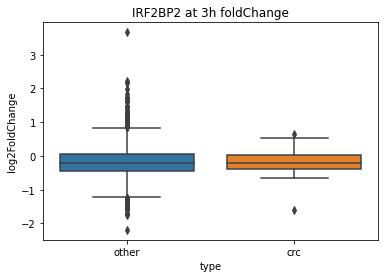

In [131]:
ax = sns.boxplot(data=res,x='type',y='log2FoldChange').set_title("IRF2BP2 at 3h foldChange")
fig_file = '../results/'+project+"/plots/"+project+"_"+scaling+"_whiskersIRF2BP2_3h_logfch.pdf"
ax.figure.savefig(fig_file)
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_whiskersIRF2BP2_3h_baseMean.pdf


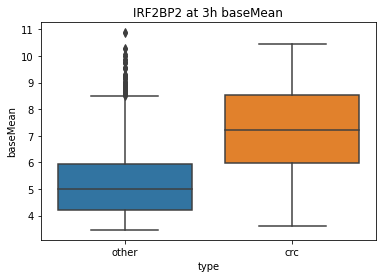

In [132]:
ax =sns.boxplot(data=res,x='type',y='baseMean').set_title("IRF2BP2 at 3h baseMean")
fig_file = '../results/'+project+"/plots/"+project+"_"+scaling+"_whiskersIRF2BP2_3h_baseMean.pdf"
ax.figure.savefig(fig_file)
print("Saved box and whisker plot to: {}".format(fig_file))

#### IRF2BP2 6h

In [123]:
resIRF2BP2_6h.baseMean.quantile([0,0.45,0.5,0.75,1])

0.00      0.000000
0.45      1.502293
0.50      2.125793
0.75      8.618345
1.00    792.305610
Name: baseMean, dtype: float64

In [124]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = resIRF2BP2_6h[resIRF2BP2_6h.baseMean>10]
res.baseMean= np.log2(1+res.baseMean)
res["type"] = ['crc' if i else "other" for i in  res.genes.isin(crc)]
res.head()

/home/monika/anaconda3/envs/slamseq/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
2,3.567919,-0.073534,0.523147,0.140560,0.888217,0.997053,AARS1,AARS1,other
9,4.759121,-0.802452,0.347349,2.310216,0.020876,0.931416,ABL1,ABL1,other
11,4.425603,-0.300262,0.394766,0.760606,0.446892,0.997053,ABL2,ABL2,other
22,4.141529,-0.134999,0.438179,0.308091,0.758013,0.997053,ACLY,ACLY,other
26,4.286644,-0.203152,0.398038,0.510383,0.609783,0.997053,ACP1,ACP1,other


Saved box and whisker plot to: ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_whiskersIRF2BP2_6h_logfch.pdf


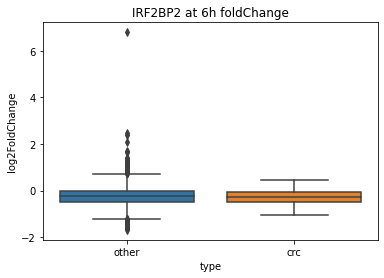

In [125]:
ax = sns.boxplot(data=res,x='type',y='log2FoldChange').set_title("IRF2BP2 at 6h foldChange")
fig_file = '../results/'+project+"/plots/"+project+"_"+scaling+"_whiskersIRF2BP2_6h_logfch.pdf"
ax.figure.savefig(fig_file)
print("Saved box and whisker plot to: {}".format(fig_file))

Saved box and whisker plot to: ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_whiskersIRF2BP2_6h_baseMean.pdf


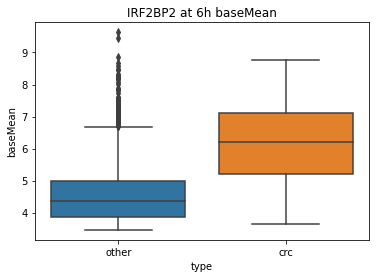

In [128]:
ax =sns.boxplot(data=res,x='type',y='baseMean').set_title("IRF2BP2 at 6h baseMean")
fig_file = '../results/'+project+"/plots/"+project+"_"+scaling+"_whiskersIRF2BP2_6h_baseMean.pdf"
ax.figure.savefig(fig_file)
print("Saved box and whisker plot to: {}".format(fig_file))

## Scatter plot comparison

#### IRF2BP2 3h vs 6h

In [133]:
mix = pd.DataFrame()
mix["gene_id"] = resIRF2BP2_3h["gene_id"]
mix['IRF2BP2 3h'] = resIRF2BP2_3h.log2FoldChange
mix['IRF2BP2 6h'] = resIRF2BP2_6h.log2FoldChange

In [135]:
print(mix.shape)
mix.head()

(15139, 3)


,gene_id,IRF2BP2 3h,IRF2BP2 6h
0,NAT1,-0.556462,1.835873
1,AAMP,0.315619,0.117255
2,AARS1,-0.109872,-0.073534
3,ABAT,-0.946852,-1.138852
4,ABCA1,-0.439957,-1.167510


In [143]:
scatter_folder = '../results/'+project+'/plots/'+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)
print(scatter_folder)


genepyPlot.scatter(mix[['IRF2BP2 3h', 'IRF2BP2 6h']].values[:12000],
                   mix['gene_id'].values.tolist()[:12000], radi= 0.06, alpha=0.3,
                   colors = [0 if i in crc else 1 for i in mix['gene_id'].values.tolist()[:12000]],
                   xname="IRF2BP2 3h", yname="IRF2BP2 6h",
                   folder=scatter_folder,
                   title='IRF2BP2 3h vs 6h differences in logFoldChange')

../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5


Figure(id='2237', ...)

## Regular volcanos

In [163]:
from genepy.utils import helper as h
from genepy.utils import plot as genepyPlot
from genepy.rna import pyDESeq2
import genepy.rna as rna

#### IRF2BP2 3h

In [144]:
res_file = "../results/"+project+"/"+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)+'_IRF2BP2_3h_deseq.csv'
resIRF2BP2_3h.to_csv(res_file)

print("Saved DESeq results to: {}".format(res_file))

Saved DESeq results to: ../results/IRF2BP2_degraded_YKL_v1/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_IRF2BP2_3h_deseq.csv


In [146]:
resIRF2BP2_3h.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,5.019967,-0.556462,0.738811,0.753185,0.451339,NaN,NAT1,NAT1
1,14.549214,0.315619,0.385422,-0.818892,0.412848,0.644171,AAMP,AAMP
2,16.044563,-0.109872,0.395827,0.277577,0.781337,0.885655,AARS1,AARS1
3,1.695828,-0.946852,1.260507,0.751167,0.452552,NaN,ABAT,ABAT
4,6.332239,-0.439957,0.569045,0.773150,0.439434,NaN,ABCA1,ABCA1


In [165]:
volcano_folder = "../results/{0}/plots/{0}_{1}_{2}_{3}".format(project, scaling, minvar_toremove, mincount_toremove)
print(volcano_folder)

genepyPlot.volcano(resIRF2BP2_3h, tohighlight=crc, searchbox=True, 
                   title='MV411 IRF2BP2 dTAG at 3h', 
                   folder=volcano_folder)

../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5
Attempting to save figure to ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_MV411_IRF2BP2_dTAG_at_3h_volcano.html


Column(id='6969', ...)

#### IRF2BP2 6h

In [145]:
res_file = "../results/"+project+"/"+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)+'_IRF2BP2_6h_deseq.csv'
resIRF2BP2_6h.to_csv(res_file)

print("Saved DESeq results to: {}".format(res_file))

Saved DESeq results to: ../results/IRF2BP2_degraded_YKL_v1/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_IRF2BP2_6h_deseq.csv


In [147]:
resIRF2BP2_6h.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.679474,1.835873,1.882485,-0.975239,0.329442,0.997053,NAT1,NAT1
1,6.895730,0.117255,0.620358,-0.189013,0.850083,0.997053,AAMP,AAMP
2,10.859066,-0.073534,0.523147,0.140560,0.888217,0.997053,AARS1,AARS1
3,0.633716,-1.138852,2.091871,0.544418,0.586154,0.997053,ABAT,ABAT
4,1.383080,-1.167510,1.382278,0.844627,0.398319,0.997053,ABCA1,ABCA1


In [164]:
volcano_folder = "../results/{0}/plots/{0}_{1}_{2}_{3}".format(project, scaling, minvar_toremove, mincount_toremove)
#volcano_folder = '../results/'+project+'/plots/'+project+'_'+scaling+"_"+str(minvar_toremove)+'_'+str(mincount_toremove)
print(volcano_folder)

genepyPlot.volcano(resIRF2BP2_6h, tohighlight=crc, searchbox=True, 
                   title='MV411 IRF2BP2 dTAG at 6h', 
                   folder=volcano_folder)

../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5
Attempting to save figure to ../results/IRF2BP2_degraded_YKL_v1/plots/IRF2BP2_degraded_YKL_v1_ERCCsamplewise_0_5_MV411_IRF2BP2_dTAG_at_6h_volcano.html


Column(id='6539', ...)